The implementation of the InceptionV3 architecture in this project is based on the InceptionV3 Algorithm implementation presented in the "Deep Learning with Python, 2nd Edition" book. The project also draws significant inspiration and follows the structure provided in a paper by Aditya Naik (2021) titled "X-ray image classification using Transfer Learning", which can be found at https://www.kaggle.com/code/adityanaik42/x-ray-image-classification-using-transfer-learning.

Chest X-Ray Pathosis Classification using InceptionV3

Importing the Dependencies

In [ ]:
import tensorflow as tf                                  #Checking for Tensorflow and supporting settings for GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import gc
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.keras.backend.clear_session()


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
%matplotlib inline

Data Extraction

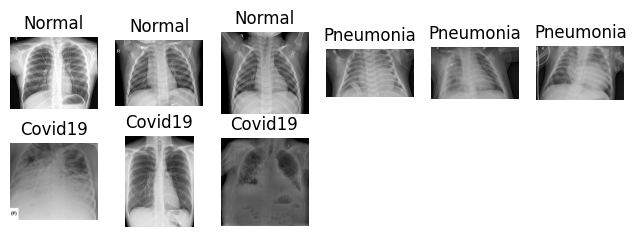

In [ ]:
PATH = "C:/Users/yashs/Downloads/Data"

import os

def extract_images(chest_xray_path):                #Defining an data extraction function Report Section 2.1
    train_data = []
    test_data = []

    for subfolder in ['PNEUMONIA', 'NORMAL', 'COVID19']:
        train_subfolder_path = os.path.join(chest_xray_path, 'train', subfolder)
        test_subfolder_path = os.path.join(chest_xray_path, 'test', subfolder)


        for image_filename in os.listdir(train_subfolder_path):
            train_data.append(os.path.join(train_subfolder_path, image_filename))

        for image_filename in os.listdir(test_subfolder_path):
            test_data.append(os.path.join(test_subfolder_path, image_filename))

    return train_data, test_data

train_set, test_set = extract_images(PATH)



def plot_train_images(train_data):                #Visiualising the images Report Section 2.1
    train_data = []

    fig = plt.figure(figsize=(12, 4))


    normal_indices = random.sample([i for i, path in enumerate(train_data) if 'NORMAL' in path], 3)
    pneumonia_indices = random.sample([i for i, path in enumerate(train_data) if 'PNEUMONIA' in path], 3)
    covid19_indices = random.sample([i for i, path in enumerate(train_data) if 'COVID19' in path], 3)


    for i, idx in enumerate(normal_indices):
        img = mpimg.imread(train_data[idx])
        ax = fig.add_subplot(3, 9, i+1)
        ax.imshow(img, cmap='gray')
        ax.set_title('Normal')
        ax.axis('off')

    for i, idx in enumerate(pneumonia_indices):
        img = mpimg.imread(train_data[idx])
        ax = fig.add_subplot(3, 9, i+4)
        ax.imshow(img, cmap='gray')
        ax.set_title('Pneumonia')
        ax.axis('off')

    for i, idx in enumerate(covid19_indices):
        img = mpimg.imread(train_data[idx])
        ax = fig.add_subplot(3, 9, i+10)
        ax.imshow(img, cmap='gray')
        ax.set_title('Covid19')
        ax.axis('off')

    plt.show()

plot_train_images(train_set)

C:/Users/yashs/Downloads/Data\train\NORMAL\NORMAL(10).jpg
(2155, 2443, 3)


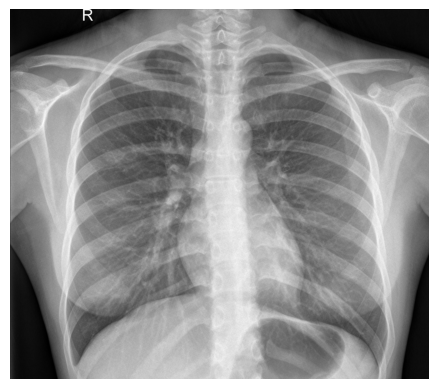

C:/Users/yashs/Downloads/Data\train\NORMAL\NORMAL(100).jpg
(1615, 1860, 3)


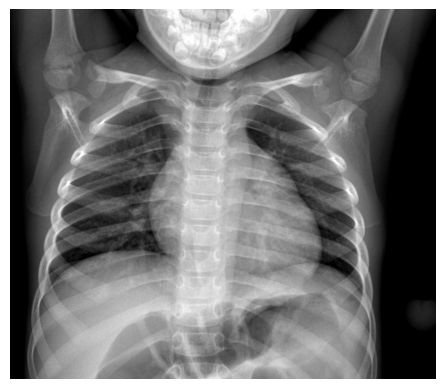

C:/Users/yashs/Downloads/Data\train\COVID19\COVID19(10).jpg
(1031, 1038, 3)


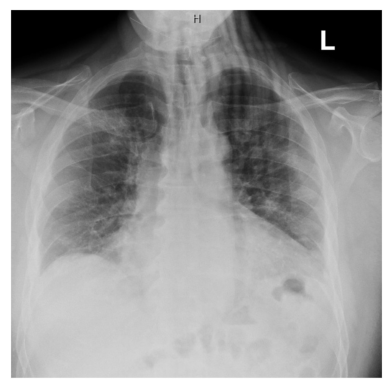

C:/Users/yashs/Downloads/Data\train\COVID19\COVID19(100).jpg
(1210, 1353, 3)


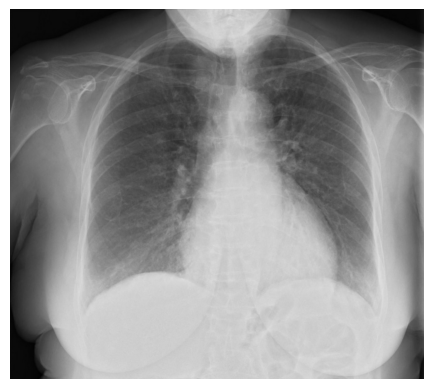

C:/Users/yashs/Downloads/Data\train\PNEUMONIA\PNEUMONIA(10).jpg
(1039, 1427, 3)


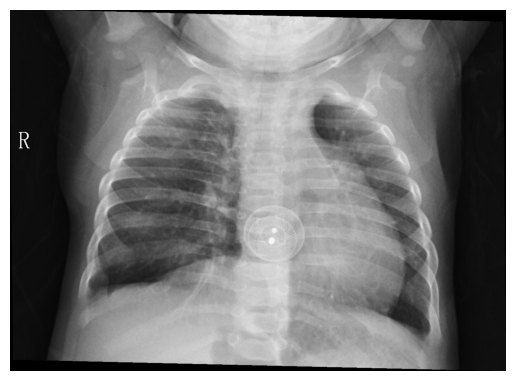

C:/Users/yashs/Downloads/Data\train\PNEUMONIA\PNEUMONIA(100).jpg
(1138, 1536, 3)


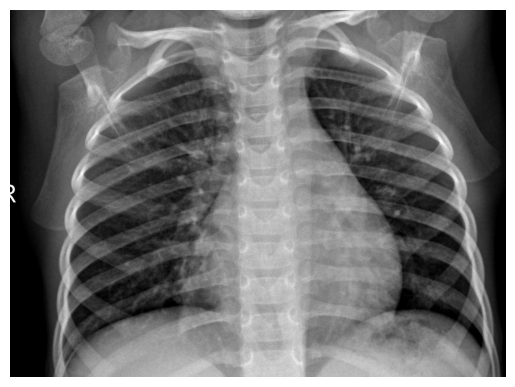

In [ ]:


base_directory = 'C:/Users/yashs/Downloads/Data'                      #Data extraction function Report Section 2.1
train_directory = os.path.join(base_directory, 'train')
test_directory = os.path.join(base_directory, 'test')


normal_images = os.path.join(train_directory, 'NORMAL')
covid_images = os.path.join(train_directory, 'COVID19')
pneumonia_images = os.path.join(train_directory, 'PNEUMONIA')


normal_images_test = os.path.join(test_directory, 'NORMAL')
covid_images_test = os.path.join(test_directory, 'COVID19')
pneumonia_images_test = os.path.join(test_directory, 'PNEUMONIA')


for d in [normal_images, covid_images, pneumonia_images]:
    temp = []
    for dirname, _, filenames in os.walk(d):
        for filename in filenames:
            temp.append(os.path.join(dirname, filename))
    if d == normal_images:
        df_normal = pd.DataFrame(temp)
    if d == covid_images:
        df_covid = pd.DataFrame(temp)
    if d == pneumonia_images:
        df_pneumonia = pd.DataFrame(temp)


for d in [normal_images_test, covid_images_test, pneumonia_images_test]:
    temp = []
    for dirname, _, filenames in os.walk(d):
        for filename in filenames:
            temp.append(os.path.join(dirname, filename))
    if d == normal_images_test:
        df_normal_test = pd.DataFrame(temp)
    if d == covid_images_test:
        df_covid_test = pd.DataFrame(temp)
    if d == pneumonia_images_test:
        df_pneumonia_test = pd.DataFrame(temp)

normal_files = os.listdir(normal_images)
covid_files = os.listdir(covid_images)
pneumonia_files = os.listdir(pneumonia_images)


pic_index = 4

normal = [os.path.join(normal_images, fname)
                for fname in normal_files[pic_index-2:pic_index]]
covid = [os.path.join(covid_images, fname)
                for fname in covid_files[pic_index-2:pic_index]]
pneumonia = [os.path.join(pneumonia_images, fname)
                for fname in pneumonia_files[pic_index-2:pic_index]]

for i, img_path in enumerate(normal+covid+pneumonia):
    print(img_path)
    img = mpimg.imread(img_path)
    print(img.shape)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

Data Preprocessing

In [ ]:
df_normal.rename(columns = {0:'images'}, inplace = True)              #Checking the number of images in dataset Report Section 2.2
df_normal['target'] = 'NORMAL'

df_normal_test.rename(columns = {0:'images'}, inplace = True)
df_normal_test['target'] = 'NORMAL'

df_covid.rename(columns = {0:'images'}, inplace = True)
df_covid['target'] = 'COVID19'

df_covid_test.rename(columns = {0:'images'}, inplace = True)
df_covid_test['target'] = 'COVID19'

df_pneumonia.rename(columns = {0:'images'}, inplace = True)
df_pneumonia['target'] = 'PNEUMONIA'

df_pneumonia_test.rename(columns = {0:'images'}, inplace = True)
df_pneumonia_test['target'] = 'PNEUMONIA'

print('No. of training images of Normal X-rays: ', len(df_normal))
print('No. of training images of Covid X-rays: ', len(df_covid))
print('No. of training images of Pneumonia X-rays: ', len(df_pneumonia))


No. of training images of Normal X-rays:  1266
No. of training images of Covid X-rays:  460
No. of training images of Pneumonia X-rays:  3418


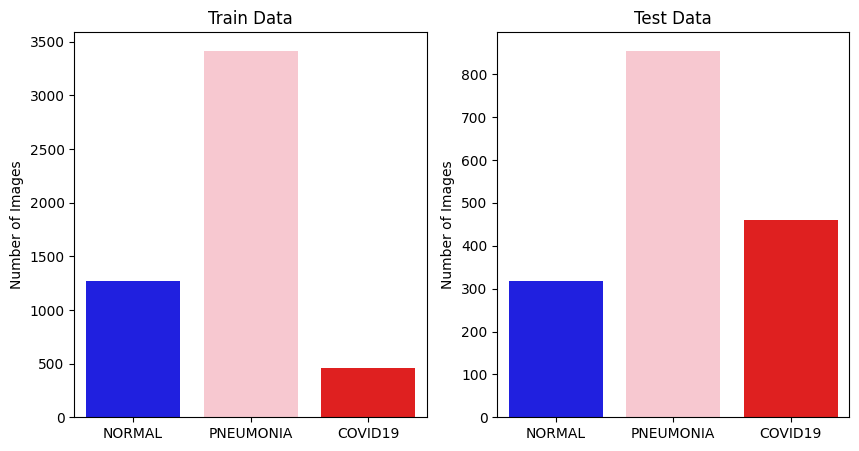

In [ ]:
train_path = PATH + '/train'                                     #Report Section 2.2
test_path = PATH + '/test'


train_pneumonia_dir = os.path.join(train_path, 'PNEUMONIA')   # Get number of images in each category for train data
train_normal_dir = os.path.join(train_path, 'NORMAL')
train_covid_dir = os.path.join(train_path, 'COVID19')
num_train_pneumonia = len(os.listdir(train_pneumonia_dir))
num_train_normal = len(os.listdir(train_normal_dir))
num_train_covid = len(os.listdir(train_covid_dir))


test_pneumonia_dir = os.path.join(test_path, 'PNEUMONIA')  # Get number of images in each category for test data
test_normal_dir = os.path.join(test_path, 'NORMAL')
test_covid_dir = os.path.join(test_path, 'COVID19')
num_test_pneumonia = len(os.listdir(test_pneumonia_dir))
num_test_normal = len(os.listdir(test_normal_dir))
num_test_covid = len(os.listdir(test_covid_dir))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.barplot(x=['NORMAL', 'PNEUMONIA', 'COVID19'], y=[num_train_normal, num_train_pneumonia, num_train_covid], palette=['blue', 'pink', 'red'], ax=ax1)
ax1.set(title='Train Data', ylabel='Number of Images')


sns.barplot(x=['NORMAL', 'PNEUMONIA', 'COVID19'], y=[num_test_normal, num_test_pneumonia, num_train_covid], palette=['blue', 'pink', 'red'], ax=ax2)
ax2.set(title='Test Data', ylabel='Number of Images')

plt.show()

Since the Dataset is unbalanced, we will be sampling 460 images from Normal and Pneumonia classes.

In [ ]:
df_normal_new = df_normal.sample(460)
df_pneumonia_new = df_pneumonia.sample(460)

print('No. of training images of Normal X-rays: ', len(df_normal_new))
print('No. of training images of Covid X-rays: ', len(df_covid))
print('No. of training images of Pneumonia X-rays: ', len(df_pneumonia_new))

train_data = pd.concat([df_normal_new, df_covid, df_pneumonia_new], axis = 0)
print('Number of training images: ',len(train_data))
np.random.RandomState(42)
train_data = train_data.sample(frac = 1, random_state = 42)
train_data.head()

No. of training images of Normal X-rays:  460
No. of training images of Covid X-rays:  460
No. of training images of Pneumonia X-rays:  460
Number of training images:  1380


,images,target
1229,C:/Users/yashs/Downloads/Data\train\NORMAL\NOR...,NORMAL
88,C:/Users/yashs/Downloads/Data\train\COVID19\CO...,COVID19
110,C:/Users/yashs/Downloads/Data\train\PNEUMONIA\...,PNEUMONIA
3374,C:/Users/yashs/Downloads/Data\train\PNEUMONIA\...,PNEUMONIA
21,C:/Users/yashs/Downloads/Data\train\COVID19\CO...,COVID19


In [ ]:
print('No. of test images of Normal X-rays: ', len(df_normal_test))
print('No. of test images of Covid X-rays: ', len(df_covid_test))
print('No. of test images of Pneumonia X-rays: ', len(df_pneumonia_test))


test_data = pd.concat([df_normal_test, df_covid_test, df_pneumonia_test], axis = 0)
print('Number of test images: ',len(test_data))
test_data.head()

No. of test images of Normal X-rays:  317
No. of test images of Covid X-rays:  116
No. of test images of Pneumonia X-rays:  855
Number of test images:  1288


,images,target
0,C:/Users/yashs/Downloads/Data\test\NORMAL\NORM...,NORMAL
1,C:/Users/yashs/Downloads/Data\test\NORMAL\NORM...,NORMAL
2,C:/Users/yashs/Downloads/Data\test\NORMAL\NORM...,NORMAL
3,C:/Users/yashs/Downloads/Data\test\NORMAL\NORM...,NORMAL
4,C:/Users/yashs/Downloads/Data\test\NORMAL\NORM...,NORMAL


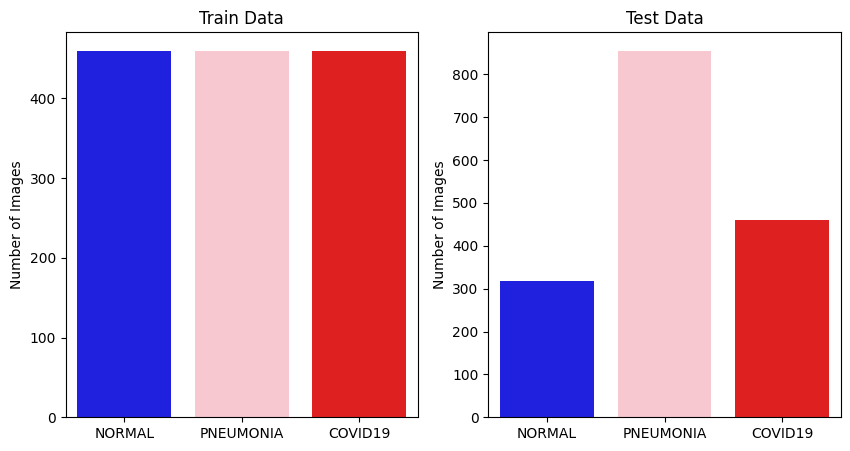

In [ ]:
num_train_pneumonia = len(df_pneumonia_new)
num_train_normal = len(df_normal_new)
num_train_covid = len(df_covid)

num_test_pneumonia = len(os.listdir(test_pneumonia_dir))
num_test_normal = len(os.listdir(test_normal_dir))
num_test_covid = len(os.listdir(test_covid_dir))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))    # Create subplot for train data

sns.barplot(x=['NORMAL', 'PNEUMONIA', 'COVID19'], y=[num_train_normal, num_train_pneumonia, num_train_covid], palette=['blue', 'pink', 'red'], ax=ax1)
ax1.set(title='Train Data', ylabel='Number of Images')


sns.barplot(x=['NORMAL', 'PNEUMONIA', 'COVID19'], y=[num_test_normal, num_test_pneumonia, num_train_covid], palette=['blue', 'pink', 'red'], ax=ax2)
ax2.set(title='Test Data', ylabel='Number of Images')

plt.show()

In [ ]:
print('Number of null values in the images column for train data: ', np.count_nonzero(train_data['images'].isnull()))
print('Number of null values in the target column for train data: ', np.count_nonzero(train_data['target'].isnull()))
print('Number of null values in the images column for test data: ', np.count_nonzero(test_data['images'].isnull()))
print('Number of null values in the target column for test data: ', np.count_nonzero(test_data['target'].isnull()))

Number of null values in the images column for train data:  0
Number of null values in the target column for train data:  0
Number of null values in the images column for test data:  0
Number of null values in the target column for test data:  0


Data Augumentation

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,            #Initialising the Datagenrator from tensrflow with pixel normalisation
                                  rotation_range = 10,    #adding random rotations upto 10
                                  width_shift_range = 0.10, #witdh shift for upto 10%
                                  height_shift_range = 0.10, #height shift for upto 10%
                                  horizontal_flip = True,   #horizontal flip for left and right lung position change
                                  validation_split = 0.1   #making a 10% data split for validation set
                                  )

train_data_generator = datagen.flow_from_dataframe(        # Training data section 2.2.1
    train_data,
    x_col = 'images',
    y_col = 'target',
    classes=['NORMAL', 'COVID19', 'PNEUMONIA'],
    batch_size = 8,
    target_size=(299, 299),
    shuffle = True,
    seed = 42,
    class_mode = 'sparse',
    validate_filenames = True,
    subset = 'training'
)


val_data_generator = datagen.flow_from_dataframe(      # Validation data
    train_data,
    x_col = 'images',
    y_col = 'target',
    classes=['NORMAL', 'COVID19', 'PNEUMONIA'],
    target_size=(299, 299),
    batch_size = 8,
    shuffle = True,
    seed = 42,
    class_mode = 'sparse',
    validate_filenames = True,
    subset = 'validation'
)

datagen_test = ImageDataGenerator(rescale = 1./255) #Initialising a testing Datagenrator from tensrflow with just pixel normalisation

test_data_generator = datagen_test.flow_from_dataframe(
    test_data,
    x_col = 'images',
    y_col = 'target',
    classes=['NORMAL', 'COVID19', 'PNEUMONIA'],
    batch_size = 8,
    shuffle = False,
    seed = 42,
    class_mode = 'sparse',
    validate_filenames = True,
    )

Found 1242 validated image filenames belonging to 3 classes.
Found 138 validated image filenames belonging to 3 classes.
Found 1288 validated image filenames belonging to 3 classes.


Base Model

Creating a Base Model - Section 5.2.1

In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(                   #Initialsing an inceptionet CNN with pretrained imagenet weights and keeping all layers trainable
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output) #Pooling the layers from the CNN to be fed to the DNN structure


output = tf.keras.layers.Dense(3, activation="softmax")(avg)                    # The final softmax layer as we only have 3 classes



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)  # Making the model with inputs as the CNN and output as the classification output layer


base_model.compile(optimizer = tf.keras.optimizers.Adam(),                       # Compiling the model
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

In [ ]:

epoch_val=30
history=base_model.fit(train_data_generator,epochs=30,validation_data=val_data_generator,verbose=1)  #Fitting the model to our Data

Epoch 1/30
156/156 [==============================] - 46s 230ms/step - loss: 0.5752 - sparse_categorical_accuracy: 0.7987 - val_loss: 3.4073 - val_sparse_categorical_accuracy: 0.5435
Epoch 2/30
156/156 [==============================] - 33s 210ms/step - loss: 0.3427 - sparse_categorical_accuracy: 0.8784 - val_loss: 1.4581 - val_sparse_categorical_accuracy: 0.6739
Epoch 3/30
156/156 [==============================] - 33s 209ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.7315 - val_sparse_categorical_accuracy: 0.8696
Epoch 4/30
156/156 [==============================] - 33s 208ms/step - loss: 0.2214 - sparse_categorical_accuracy: 0.9283 - val_loss: 2.2366 - val_sparse_categorical_accuracy: 0.6014
Epoch 5/30
156/156 [==============================] - 33s 212ms/step - loss: 0.2862 - sparse_categorical_accuracy: 0.9050 - val_loss: 1.6911 - val_sparse_categorical_accuracy: 0.5725
Epoch 6/30
156/156 [==============================] - 33s 210ms/step - loss: 0.2287 -

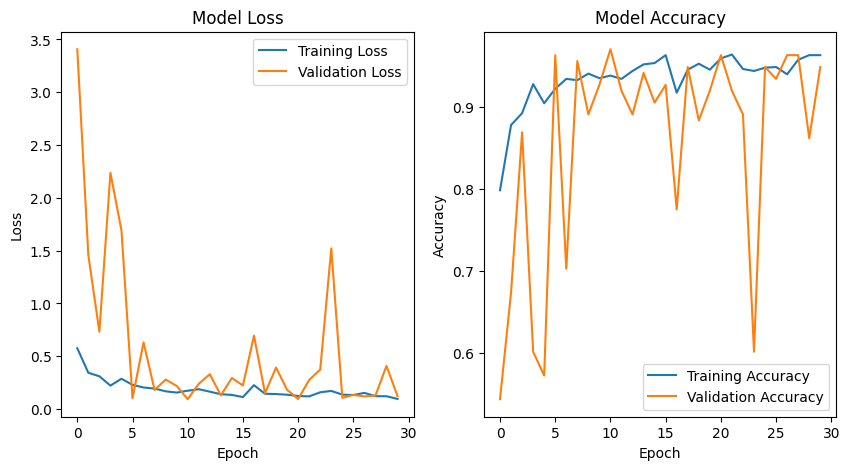

In [ ]:
train_loss = history.history['loss']                                        # Get the training and validation loss and accuracy from the history object
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))                                # Create subplots for the loss and accuracy


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


plt.show()

Hyperparameter Tuning  - Section 5.2.2

#Tuning the model for Dropout

In [ ]:
dropout_epoch=15

Dropout=0.5

Epoch 1/15
156/156 [==============================] - 45s 228ms/step - loss: 0.5758 - sparse_categorical_accuracy: 0.7689 - val_loss: 26.2728 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 33s 208ms/step - loss: 0.4178 - sparse_categorical_accuracy: 0.8519 - val_loss: 0.6142 - val_sparse_categorical_accuracy: 0.8333
Epoch 3/15
156/156 [==============================] - 32s 207ms/step - loss: 0.3837 - sparse_categorical_accuracy: 0.8543 - val_loss: 1.1177 - val_sparse_categorical_accuracy: 0.5507
Epoch 4/15
156/156 [==============================] - 33s 212ms/step - loss: 0.3444 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.4794 - val_sparse_categorical_accuracy: 0.8406
Epoch 5/15
156/156 [==============================] - 33s 210ms/step - loss: 0.3189 - sparse_categorical_accuracy: 0.8849 - val_loss: 1.1326 - val_sparse_categorical_accuracy: 0.7101
Epoch 6/15
156/156 [==============================] - 33s 212ms/step - loss: 0.2593 

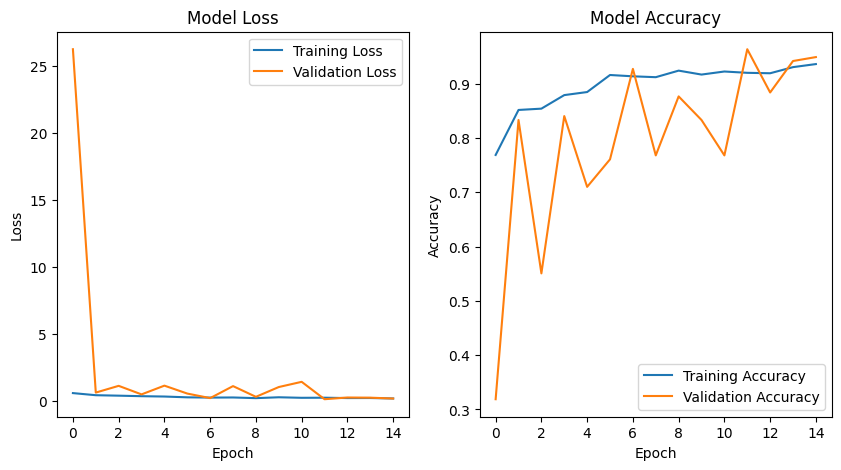

161/161 [==============================] - 12s 67ms/step
precision:  0.8242752543729693
recall:  0.9128334254663212
F1 score:  0.8598109722259185


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.5)(avg)                                  #adding dropout


output = tf.keras.layers.Dense(3, activation="softmax")(dropout)



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)


base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=dropout_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plot
plt.show()

base_model.evaluate(test_data_generator)

y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Dropout=0.6

Epoch 1/15
156/156 [==============================] - 39s 221ms/step - loss: 0.5645 - sparse_categorical_accuracy: 0.7907 - val_loss: 55.5169 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 34s 214ms/step - loss: 0.4684 - sparse_categorical_accuracy: 0.8414 - val_loss: 1.0655 - val_sparse_categorical_accuracy: 0.5217
Epoch 3/15
156/156 [==============================] - 33s 213ms/step - loss: 0.3580 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.7464
Epoch 4/15
156/156 [==============================] - 34s 217ms/step - loss: 0.3439 - sparse_categorical_accuracy: 0.8841 - val_loss: 1.0700 - val_sparse_categorical_accuracy: 0.7899
Epoch 5/15
156/156 [==============================] - 34s 218ms/step - loss: 0.3304 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.3004 - val_sparse_categorical_accuracy: 0.8913
Epoch 6/15
156/156 [==============================] - 34s 215ms/step - loss: 0.2906 

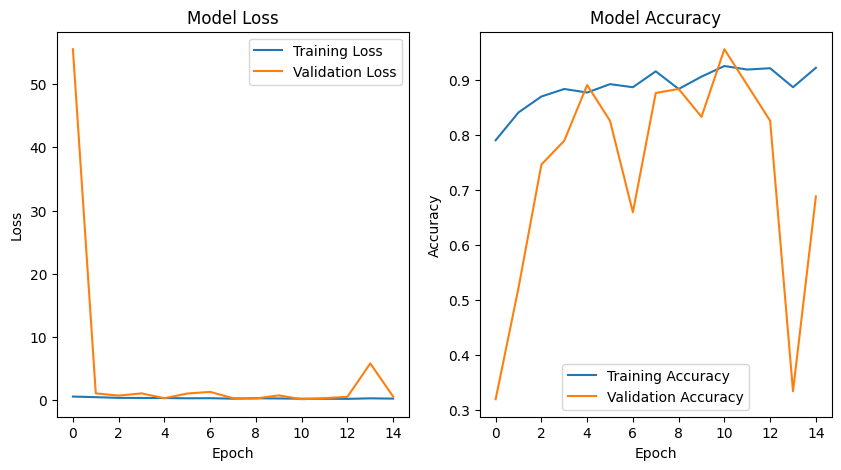

161/161 [==============================] - 12s 66ms/step
precision:  0.7501097226814274
recall:  0.7176139082855864
F1 score:  0.6625988291387531


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.6)(avg)                    #adding dropout


output = tf.keras.layers.Dense(3, activation="softmax")(dropout)



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)


base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=dropout_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


plt.show()

base_model.evaluate(test_data_generator)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Dropout=0.7

Epoch 1/15
156/156 [==============================] - 46s 232ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.7746 - val_loss: 3.0811 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 34s 215ms/step - loss: 0.4145 - sparse_categorical_accuracy: 0.8575 - val_loss: 5.7170 - val_sparse_categorical_accuracy: 0.7464
Epoch 3/15
156/156 [==============================] - 34s 214ms/step - loss: 0.3780 - sparse_categorical_accuracy: 0.8712 - val_loss: 0.3313 - val_sparse_categorical_accuracy: 0.8986
Epoch 4/15
156/156 [==============================] - 34s 215ms/step - loss: 0.2912 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.2817 - val_sparse_categorical_accuracy: 0.8768
Epoch 5/15
156/156 [==============================] - 35s 223ms/step - loss: 0.2934 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.5568 - val_sparse_categorical_accuracy: 0.7971
Epoch 6/15
156/156 [==============================] - 34s 219ms/step - loss: 0.2695 -

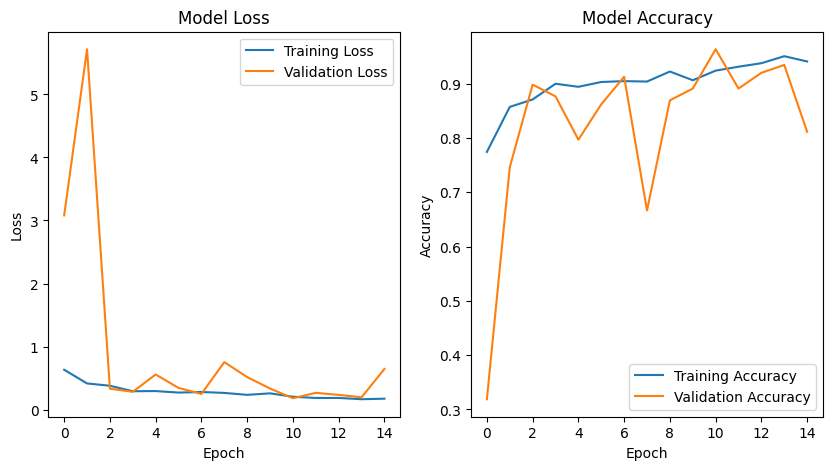

161/161 [==============================] - 12s 69ms/step
precision:  0.7321401418647474
recall:  0.8019038131606618
F1 score:  0.6987053701032208


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.7)(avg)


output = tf.keras.layers.Dense(3, activation="softmax")(dropout)



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)


base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=dropout_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


plt.show()

base_model.evaluate(test_data_generator)

y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

#Dropout=0.8

Epoch 1/15
156/156 [==============================] - 41s 231ms/step - loss: 0.6605 - sparse_categorical_accuracy: 0.7440 - val_loss: 2.9027 - val_sparse_categorical_accuracy: 0.3623
Epoch 2/15
156/156 [==============================] - 35s 222ms/step - loss: 0.5578 - sparse_categorical_accuracy: 0.8035 - val_loss: 1.3391 - val_sparse_categorical_accuracy: 0.8696
Epoch 3/15
156/156 [==============================] - 36s 229ms/step - loss: 0.3749 - sparse_categorical_accuracy: 0.8728 - val_loss: 2.9489 - val_sparse_categorical_accuracy: 0.6884
Epoch 4/15
156/156 [==============================] - 35s 224ms/step - loss: 0.4443 - sparse_categorical_accuracy: 0.8559 - val_loss: 2.8691 - val_sparse_categorical_accuracy: 0.6087
Epoch 5/15
156/156 [==============================] - 35s 224ms/step - loss: 0.3261 - sparse_categorical_accuracy: 0.8784 - val_loss: 1.3049 - val_sparse_categorical_accuracy: 0.7899
Epoch 6/15
156/156 [==============================] - 36s 228ms/step - loss: 0.3011 -

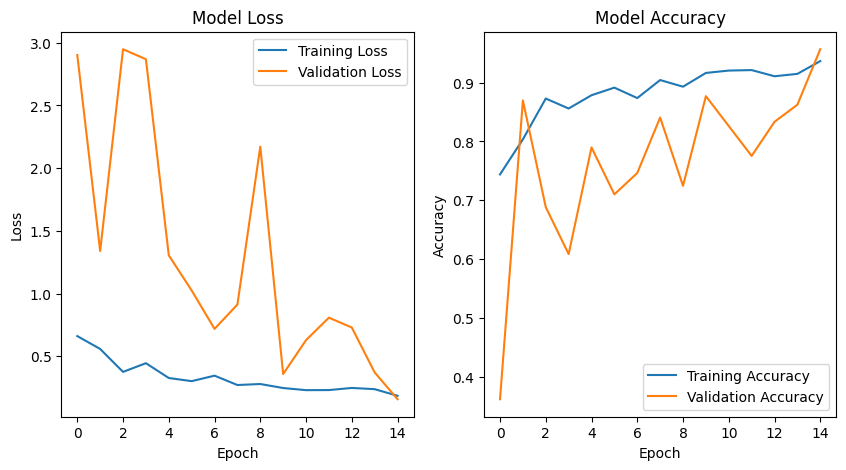

161/161 [==============================] - 12s 69ms/step
precision:  0.9061335638800427
recall:  0.939857059221049
F1 score:  0.9192908493027755


In [ ]:



pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.8)(avg)               #adding dropout


output = tf.keras.layers.Dense(3, activation="softmax")(dropout)



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)


base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=dropout_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

#Fully connected Layers

In [ ]:
layer_epoch=15

#Layer Structure 1 (1024)

Epoch 1/15
156/156 [==============================] - 45s 227ms/step - loss: 0.7719 - sparse_categorical_accuracy: 0.6804 - val_loss: 26.9240 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/15
156/156 [==============================] - 33s 212ms/step - loss: 0.6083 - sparse_categorical_accuracy: 0.7802 - val_loss: 18.1061 - val_sparse_categorical_accuracy: 0.5145
Epoch 3/15
156/156 [==============================] - 33s 210ms/step - loss: 0.4294 - sparse_categorical_accuracy: 0.8438 - val_loss: 192.3634 - val_sparse_categorical_accuracy: 0.4710
Epoch 4/15
156/156 [==============================] - 33s 211ms/step - loss: 0.4814 - sparse_categorical_accuracy: 0.8172 - val_loss: 12.4451 - val_sparse_categorical_accuracy: 0.3623
Epoch 5/15
156/156 [==============================] - 34s 216ms/step - loss: 0.4504 - sparse_categorical_accuracy: 0.8357 - val_loss: 0.6528 - val_sparse_categorical_accuracy: 0.8623
Epoch 6/15
156/156 [==============================] - 34s 214ms/step - loss: 0.3

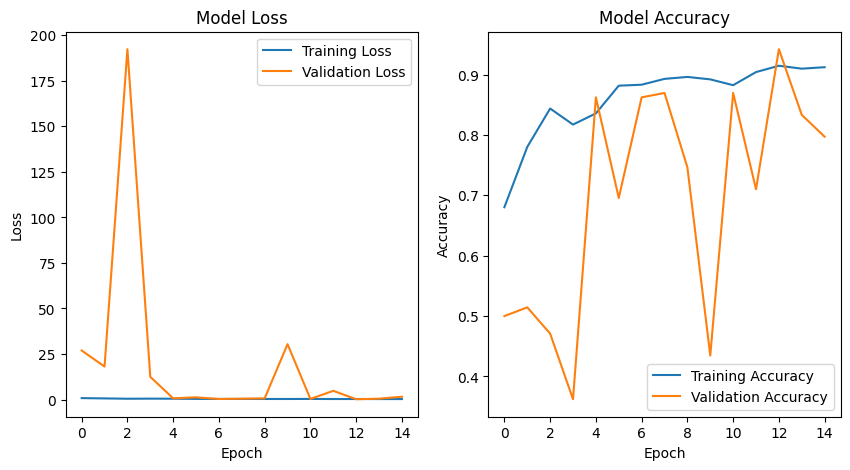

161/161 [==============================] - 12s 67ms/step
precision:  0.6062549354526522
recall:  0.6700333163062241
F1 score:  0.6295708025184817


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)            #Adding the Hidden layer Architecture


output = tf.keras.layers.Dense(3, activation="softmax")(hl1)



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)


base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

#Layer Structure 2 (1024)(512)

Epoch 1/15
156/156 [==============================] - 40s 224ms/step - loss: 0.7467 - sparse_categorical_accuracy: 0.7134 - val_loss: 19.4160 - val_sparse_categorical_accuracy: 0.3043
Epoch 2/15
156/156 [==============================] - 34s 216ms/step - loss: 0.5569 - sparse_categorical_accuracy: 0.8043 - val_loss: 0.8044 - val_sparse_categorical_accuracy: 0.7029
Epoch 3/15
156/156 [==============================] - 35s 221ms/step - loss: 0.4390 - sparse_categorical_accuracy: 0.8510 - val_loss: 4.8313 - val_sparse_categorical_accuracy: 0.5580
Epoch 4/15
156/156 [==============================] - 34s 217ms/step - loss: 0.4273 - sparse_categorical_accuracy: 0.8591 - val_loss: 0.7728 - val_sparse_categorical_accuracy: 0.7174
Epoch 5/15
156/156 [==============================] - 34s 217ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8647 - val_loss: 0.5979 - val_sparse_categorical_accuracy: 0.7101
Epoch 6/15
156/156 [==============================] - 35s 224ms/step - loss: 0.3611 

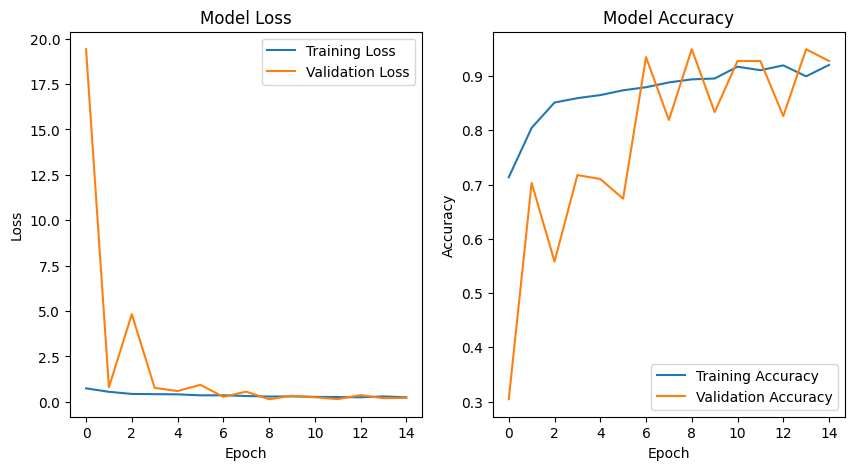

161/161 [==============================] - 12s 67ms/step
precision:  0.7524482944798966
recall:  0.868754332317856
F1 score:  0.7708875820478124


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)     #Adding the Hidden layer Architecture
hl2 = tf.keras.layers.Dense(512, activation="relu")(hl1)


output = tf.keras.layers.Dense(3, activation="softmax")(hl2)



base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)


base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Layer Structure 3 (1024)(1024)

Epoch 1/15
156/156 [==============================] - 42s 238ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.3589 - val_sparse_categorical_accuracy: 0.8841
Epoch 2/15
156/156 [==============================] - 35s 225ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.8229 - val_loss: 2065.3459 - val_sparse_categorical_accuracy: 0.3333
Epoch 3/15
156/156 [==============================] - 35s 226ms/step - loss: 0.4479 - sparse_categorical_accuracy: 0.8486 - val_loss: 7.8757 - val_sparse_categorical_accuracy: 0.5652
Epoch 4/15
156/156 [==============================] - 35s 224ms/step - loss: 0.3828 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.7971
Epoch 5/15
156/156 [==============================] - 34s 220ms/step - loss: 0.3857 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.2271 - val_sparse_categorical_accuracy: 0.9275
Epoch 6/15
156/156 [==============================] - 35s 223ms/step - loss: 0.351

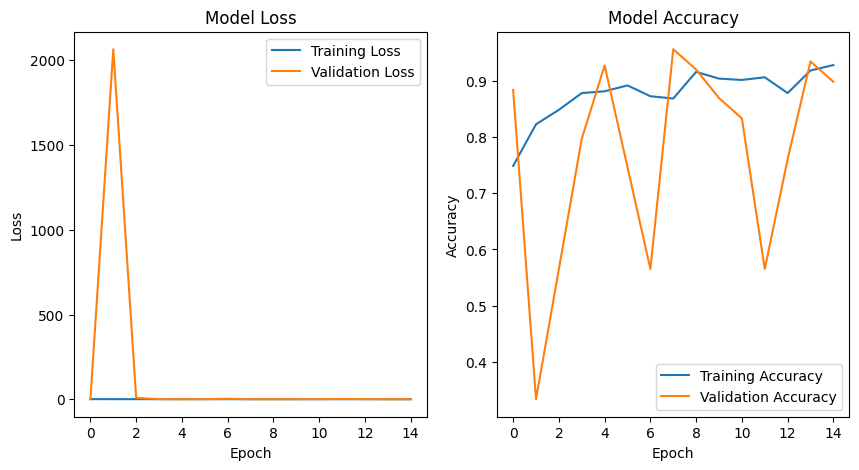

161/161 [==============================] - 12s 71ms/step
precision:  0.927780953614287
recall:  0.9346289309456365
F1 score:  0.9302524024632439


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)


avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)


dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)        #Adding the Hidden layer Architecture
hl2 = tf.keras.layers.Dense(1024, activation="relu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Layer Structure 4 (1024)(512)(256)

Epoch 1/15
156/156 [==============================] - 41s 232ms/step - loss: 0.9363 - sparse_categorical_accuracy: 0.5580 - val_loss: 3494.7310 - val_sparse_categorical_accuracy: 0.3768
Epoch 2/15
156/156 [==============================] - 36s 230ms/step - loss: 0.8126 - sparse_categorical_accuracy: 0.6071 - val_loss: 4.5610 - val_sparse_categorical_accuracy: 0.4420
Epoch 3/15
156/156 [==============================] - 35s 220ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7770 - val_loss: 0.5920 - val_sparse_categorical_accuracy: 0.8623
Epoch 4/15
156/156 [==============================] - 35s 223ms/step - loss: 0.4833 - sparse_categorical_accuracy: 0.8325 - val_loss: 8.0615 - val_sparse_categorical_accuracy: 0.4928
Epoch 5/15
156/156 [==============================] - 35s 223ms/step - loss: 0.4728 - sparse_categorical_accuracy: 0.8446 - val_loss: 0.3966 - val_sparse_categorical_accuracy: 0.8261
Epoch 6/15
156/156 [==============================] - 34s 218ms/step - loss: 0.443

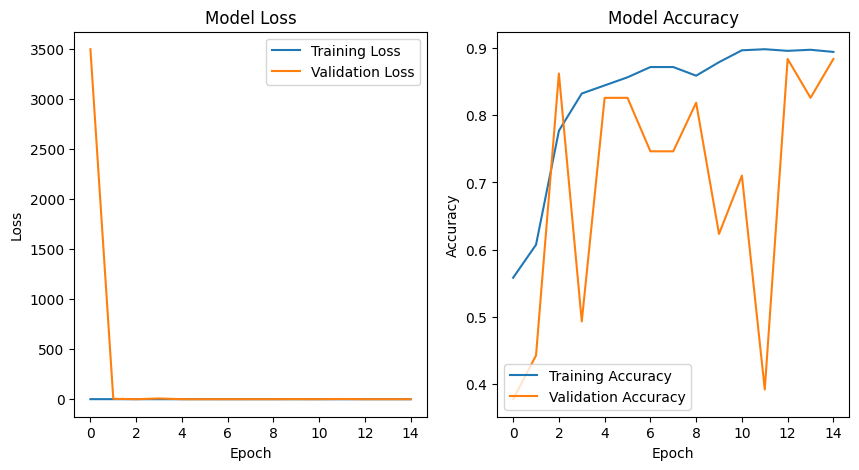

161/161 [==============================] - 12s 71ms/step
precision:  0.8519986378261585
recall:  0.8733126887586516
F1 score:  0.8458151259284974


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)                #Adding the Hidden layer Architecture
hl2 = tf.keras.layers.Dense(512, activation="relu")(hl1)
hl3 = tf.keras.layers.Dense(256, activation="relu")(hl2)

output = tf.keras.layers.Dense(3, activation="softmax")(hl3)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)



y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Layer Structure 5 (1024)(1024)(1024)

Epoch 1/15
156/156 [==============================] - 42s 230ms/step - loss: 0.8980 - sparse_categorical_accuracy: 0.5926 - val_loss: 279.4210 - val_sparse_categorical_accuracy: 0.3043
Epoch 2/15
156/156 [==============================] - 37s 234ms/step - loss: 0.7876 - sparse_categorical_accuracy: 0.6449 - val_loss: 33948.7617 - val_sparse_categorical_accuracy: 0.3043
Epoch 3/15
156/156 [==============================] - 36s 229ms/step - loss: 0.7858 - sparse_categorical_accuracy: 0.6304 - val_loss: 65.1984 - val_sparse_categorical_accuracy: 0.4130
Epoch 4/15
156/156 [==============================] - 36s 233ms/step - loss: 0.6303 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.9984 - val_sparse_categorical_accuracy: 0.6812
Epoch 5/15
156/156 [==============================] - 35s 222ms/step - loss: 0.4556 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.6522
Epoch 6/15
156/156 [==============================] - 35s 222ms/step - loss: 0

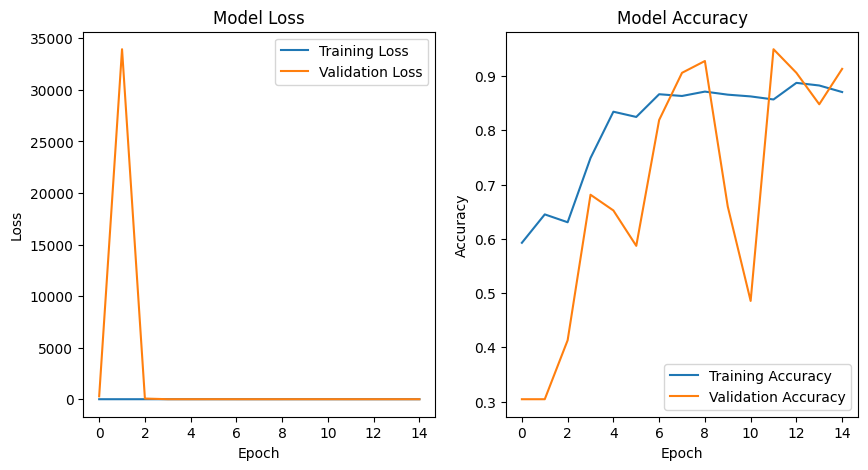

161/161 [==============================] - 12s 67ms/step
precision:  0.7355346746157719
recall:  0.8823054833016646
F1 score:  0.770703539959451


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)                #Adding the Hidden layer Architecture
hl2 = tf.keras.layers.Dense(1024, activation="relu")(hl1)
hl3 = tf.keras.layers.Dense(1024, activation="relu")(hl2)

output = tf.keras.layers.Dense(3, activation="softmax")(hl3)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Layer Structure 5 (1024)(512)(256)(128)

Epoch 1/15
156/156 [==============================] - 40s 225ms/step - loss: 0.7538 - sparse_categorical_accuracy: 0.7190 - val_loss: 20.7785 - val_sparse_categorical_accuracy: 0.5217
Epoch 2/15
156/156 [==============================] - 35s 223ms/step - loss: 0.6082 - sparse_categorical_accuracy: 0.7770 - val_loss: 5.8303 - val_sparse_categorical_accuracy: 0.5507
Epoch 3/15
156/156 [==============================] - 35s 224ms/step - loss: 0.4976 - sparse_categorical_accuracy: 0.8366 - val_loss: 5.0084 - val_sparse_categorical_accuracy: 0.3261
Epoch 4/15
156/156 [==============================] - 35s 222ms/step - loss: 0.4382 - sparse_categorical_accuracy: 0.8325 - val_loss: 1.9463 - val_sparse_categorical_accuracy: 0.5725
Epoch 5/15
156/156 [==============================] - 35s 225ms/step - loss: 0.4981 - sparse_categorical_accuracy: 0.8285 - val_loss: 2.8292 - val_sparse_categorical_accuracy: 0.5942
Epoch 6/15
156/156 [==============================] - 35s 224ms/step - loss: 0.4898 

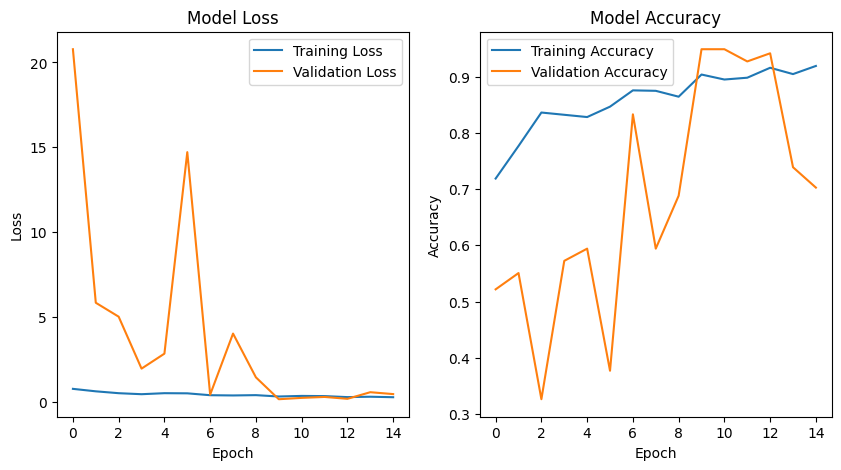

161/161 [==============================] - 12s 67ms/step
precision:  0.8257777575539372
recall:  0.8085548182796088
F1 score:  0.8009077223076178


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)              #Adding the Hidden layer Architecture
hl2 = tf.keras.layers.Dense(512, activation="relu")(hl1)
hl3 = tf.keras.layers.Dense(256, activation="relu")(hl2)
hl4 = tf.keras.layers.Dense(128, activation="relu")(hl3)

output = tf.keras.layers.Dense(3, activation="softmax")(hl4)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Layer Structure 6 (1024)(1024)(1024)(1024)

Epoch 1/15
156/156 [==============================] - 49s 253ms/step - loss: 0.9115 - sparse_categorical_accuracy: 0.5386 - val_loss: 3.2385 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 34s 220ms/step - loss: 0.7564 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.0994 - val_sparse_categorical_accuracy: 0.6522
Epoch 3/15
156/156 [==============================] - 34s 220ms/step - loss: 0.6363 - sparse_categorical_accuracy: 0.7053 - val_loss: 132.2824 - val_sparse_categorical_accuracy: 0.4420
Epoch 4/15
156/156 [==============================] - 34s 217ms/step - loss: 0.7011 - sparse_categorical_accuracy: 0.7037 - val_loss: 0.8852 - val_sparse_categorical_accuracy: 0.6739
Epoch 5/15
156/156 [==============================] - 34s 220ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.7713 - val_loss: 6.4855 - val_sparse_categorical_accuracy: 0.4348
Epoch 6/15
156/156 [==============================] - 35s 222ms/step - loss: 0.6172

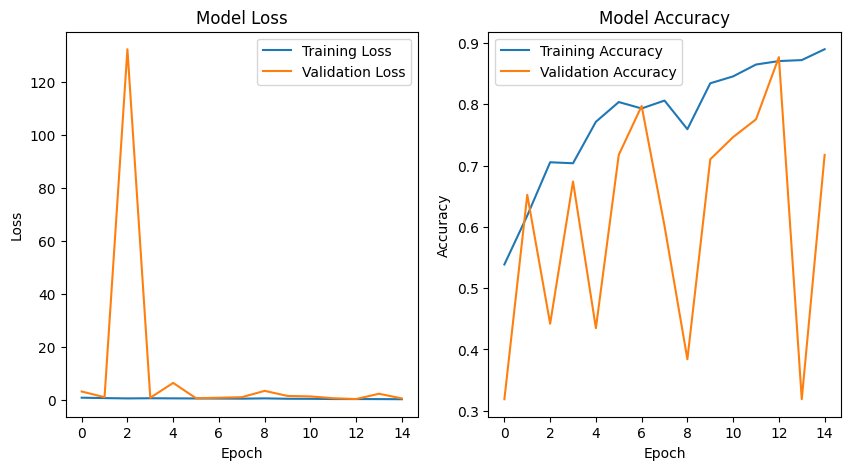

161/161 [==============================] - 11s 65ms/step
precision:  0.578397175319299
recall:  0.503172407007705
F1 score:  0.5116299171323094


C:\Users\yashs\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="relu")(hl1)
hl3 = tf.keras.layers.Dense(1024, activation="relu")(hl2)
hl4 = tf.keras.layers.Dense(1024, activation="relu")(hl3)

output = tf.keras.layers.Dense(3, activation="softmax")(hl4)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=layer_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Activation Function

In [ ]:
activation_epoch=15

Relu

Epoch 1/15
156/156 [==============================] - 46s 230ms/step - loss: 0.7762 - sparse_categorical_accuracy: 0.7101 - val_loss: 8.1212 - val_sparse_categorical_accuracy: 0.2174
Epoch 2/15
156/156 [==============================] - 34s 216ms/step - loss: 0.5160 - sparse_categorical_accuracy: 0.8100 - val_loss: 9.7044 - val_sparse_categorical_accuracy: 0.4130
Epoch 3/15
156/156 [==============================] - 34s 215ms/step - loss: 0.4503 - sparse_categorical_accuracy: 0.8510 - val_loss: 1.1473 - val_sparse_categorical_accuracy: 0.8406
Epoch 4/15
156/156 [==============================] - 34s 215ms/step - loss: 0.3734 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.7464
Epoch 5/15
156/156 [==============================] - 34s 215ms/step - loss: 0.3649 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.4966 - val_sparse_categorical_accuracy: 0.8333
Epoch 6/15
156/156 [==============================] - 34s 218ms/step - loss: 0.3108 -

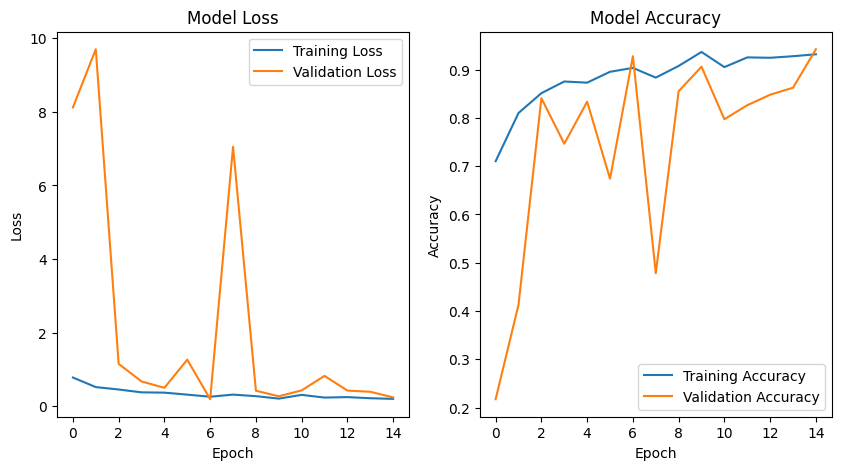

161/161 [==============================] - 11s 65ms/step
precision:  0.7507570163240421
recall:  0.8705418925197131
F1 score:  0.7743810019158396


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="relu")(dropout)        #Chaning the activation in the hidden layers
hl2 = tf.keras.layers.Dense(1024, activation="relu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=activation_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

LeakyReLU

Epoch 1/15
156/156 [==============================] - 39s 219ms/step - loss: 0.9058 - sparse_categorical_accuracy: 0.6804 - val_loss: 6.3786 - val_sparse_categorical_accuracy: 0.3116
Epoch 2/15
156/156 [==============================] - 34s 214ms/step - loss: 0.7105 - sparse_categorical_accuracy: 0.7327 - val_loss: 5.9487 - val_sparse_categorical_accuracy: 0.4130
Epoch 3/15
156/156 [==============================] - 34s 217ms/step - loss: 0.5212 - sparse_categorical_accuracy: 0.8164 - val_loss: 1.0785 - val_sparse_categorical_accuracy: 0.7971
Epoch 4/15
156/156 [==============================] - 34s 217ms/step - loss: 0.4575 - sparse_categorical_accuracy: 0.8277 - val_loss: 0.6230 - val_sparse_categorical_accuracy: 0.8333
Epoch 5/15
156/156 [==============================] - 34s 214ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.9390 - val_sparse_categorical_accuracy: 0.8043
Epoch 6/15
156/156 [==============================] - 34s 216ms/step - loss: 0.3145 -

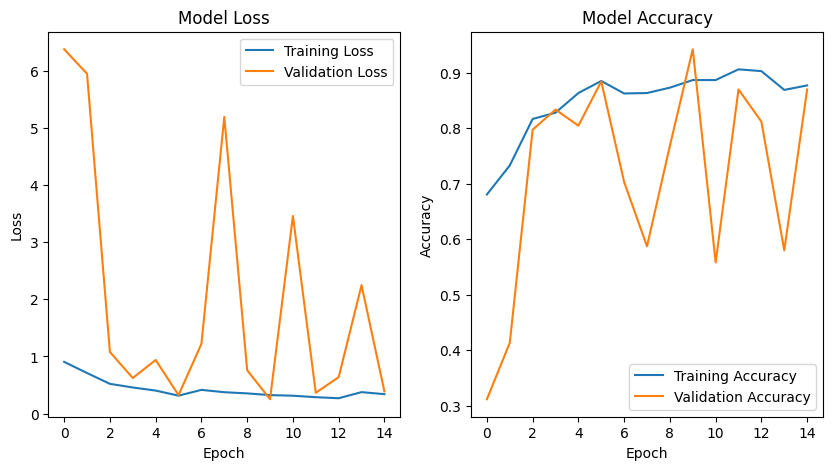

161/161 [==============================] - 12s 66ms/step
precision:  0.798043433376504
recall:  0.8421826803129511
F1 score:  0.7768028898463681


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="LeakyReLU")(dropout)              #Chaning the activation in the hidden layers
hl2 = tf.keras.layers.Dense(1024, activation="LeakyReLU")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=activation_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

ELU

Epoch 1/15
156/156 [==============================] - 40s 221ms/step - loss: 0.9509 - sparse_categorical_accuracy: 0.7238 - val_loss: 252803.4844 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 33s 212ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.7890 - val_loss: 260.5142 - val_sparse_categorical_accuracy: 0.3478
Epoch 3/15
156/156 [==============================] - 33s 213ms/step - loss: 0.6597 - sparse_categorical_accuracy: 0.7576 - val_loss: 2.4238 - val_sparse_categorical_accuracy: 0.3406
Epoch 4/15
156/156 [==============================] - 34s 216ms/step - loss: 0.5146 - sparse_categorical_accuracy: 0.8148 - val_loss: 4.1223 - val_sparse_categorical_accuracy: 0.4855
Epoch 5/15
156/156 [==============================] - 34s 218ms/step - loss: 0.5084 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.6557 - val_sparse_categorical_accuracy: 0.8043
Epoch 6/15
156/156 [==============================] - 34s 217ms/step - loss: 0

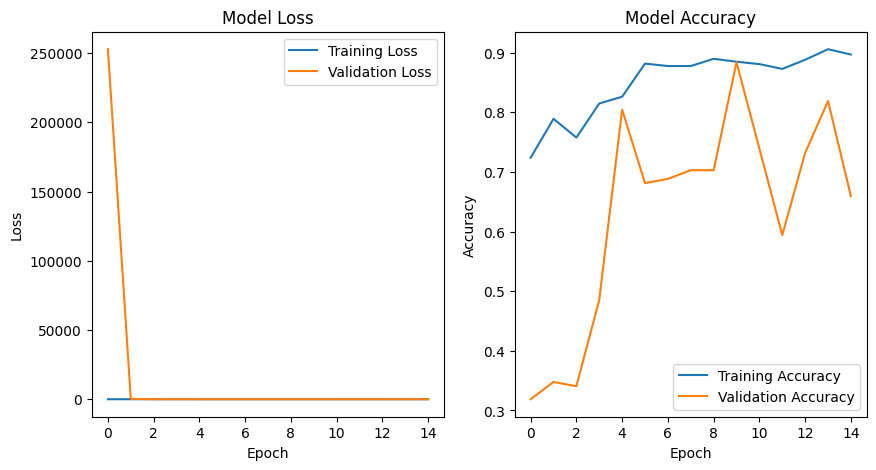

161/161 [==============================] - 12s 66ms/step
precision:  0.8547902366215623
recall:  0.7825403535065348
F1 score:  0.778700965094813


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)        #Chaning the activation in the hidden layers
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=activation_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Optimizers

In [ ]:
opt_epoch=15

Adam

Epoch 1/15
156/156 [==============================] - 51s 237ms/step - loss: 0.9530 - sparse_categorical_accuracy: 0.7343 - val_loss: 67.7585 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 32s 206ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.7810 - val_loss: 1.9485 - val_sparse_categorical_accuracy: 0.5725
Epoch 3/15
156/156 [==============================] - 33s 209ms/step - loss: 0.6185 - sparse_categorical_accuracy: 0.7552 - val_loss: 1.1994 - val_sparse_categorical_accuracy: 0.6594
Epoch 4/15
156/156 [==============================] - 32s 207ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.7432 - val_loss: 16.7071 - val_sparse_categorical_accuracy: 0.3913
Epoch 5/15
156/156 [==============================] - 33s 210ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.8003 - val_loss: 1.6947 - val_sparse_categorical_accuracy: 0.4420
Epoch 6/15
156/156 [==============================] - 33s 212ms/step - loss: 0.5485

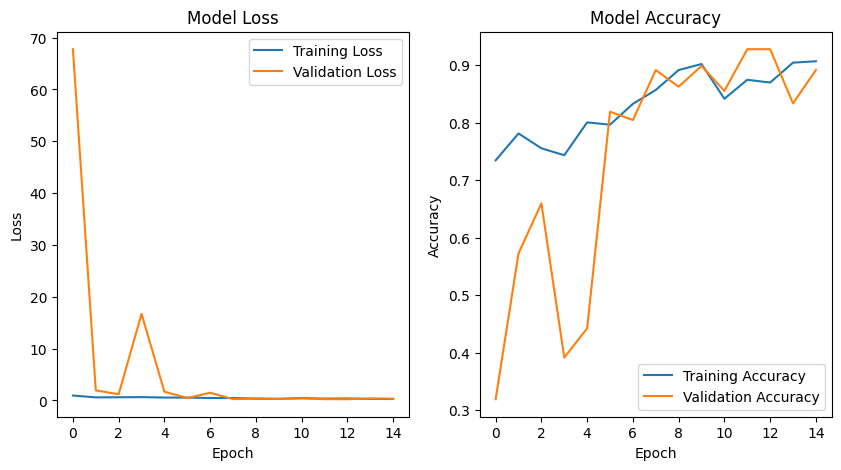

161/161 [==============================] - 11s 66ms/step
precision:  0.9200974016785276
recall:  0.9382564367455618
F1 score:  0.9282353754274922


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=opt_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Adagrad

Epoch 1/15
156/156 [==============================] - 39s 218ms/step - loss: 0.5657 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.2595 - val_sparse_categorical_accuracy: 0.9058
Epoch 2/15
156/156 [==============================] - 34s 215ms/step - loss: 0.3203 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.1164 - val_sparse_categorical_accuracy: 0.9783
Epoch 3/15
156/156 [==============================] - 34s 216ms/step - loss: 0.2448 - sparse_categorical_accuracy: 0.9138 - val_loss: 0.0593 - val_sparse_categorical_accuracy: 0.9855
Epoch 4/15
156/156 [==============================] - 34s 219ms/step - loss: 0.2126 - sparse_categorical_accuracy: 0.9291 - val_loss: 0.0710 - val_sparse_categorical_accuracy: 0.9783
Epoch 5/15
156/156 [==============================] - 33s 213ms/step - loss: 0.2053 - sparse_categorical_accuracy: 0.9316 - val_loss: 0.0523 - val_sparse_categorical_accuracy: 0.9855
Epoch 6/15
156/156 [==============================] - 34s 216ms/step - loss: 0.1524 -

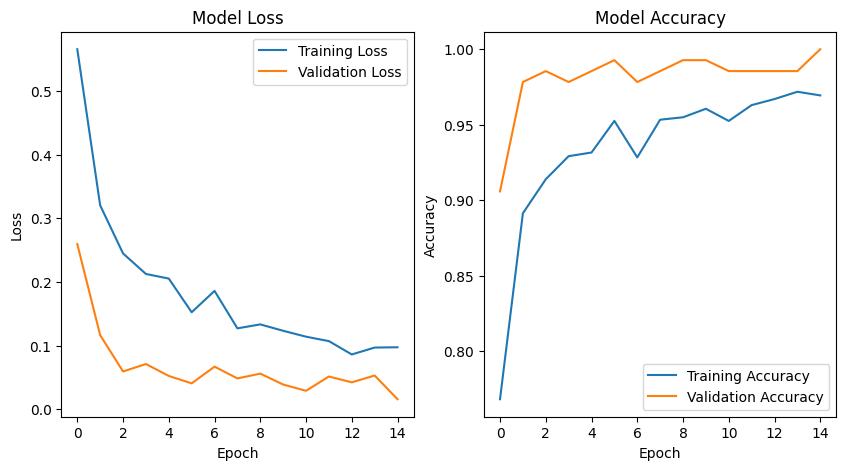

161/161 [==============================] - 11s 66ms/step
precision:  0.849779016020442
recall:  0.9242127400520227
F1 score:  0.8690333046015057


In [ ]:


pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adagrad(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=opt_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

RMSprop

Epoch 1/15
156/156 [==============================] - 47s 247ms/step - loss: 1.6147 - sparse_categorical_accuracy: 0.4992 - val_loss: 46633.7188 - val_sparse_categorical_accuracy: 0.3696
Epoch 2/15
156/156 [==============================] - 38s 241ms/step - loss: 1.1224 - sparse_categorical_accuracy: 0.5161 - val_loss: 3.4398 - val_sparse_categorical_accuracy: 0.5652
Epoch 3/15
156/156 [==============================] - 38s 243ms/step - loss: 0.8611 - sparse_categorical_accuracy: 0.6699 - val_loss: 318.4218 - val_sparse_categorical_accuracy: 0.3986
Epoch 4/15
156/156 [==============================] - 38s 242ms/step - loss: 0.7499 - sparse_categorical_accuracy: 0.7230 - val_loss: 1.2152 - val_sparse_categorical_accuracy: 0.7754
Epoch 5/15
156/156 [==============================] - 38s 243ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.7762 - val_loss: 1.4027 - val_sparse_categorical_accuracy: 0.7609
Epoch 6/15
156/156 [==============================] - 38s 243ms/step - loss: 0.

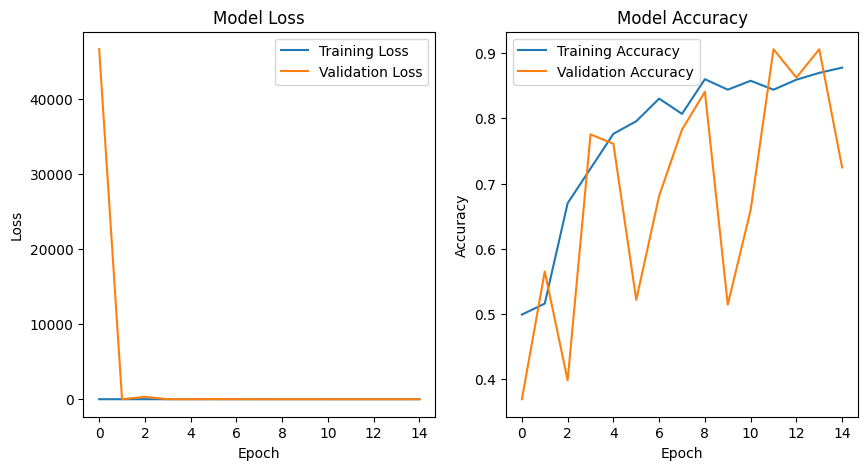

161/161 [==============================] - 12s 68ms/step
precision:  0.908516408722751
recall:  0.8543697753757468
F1 score:  0.8790177605116397


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.RMSprop(),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=opt_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

SGD+M

Epoch 1/15
156/156 [==============================] - 40s 225ms/step - loss: 0.7172 - sparse_categorical_accuracy: 0.7536 - val_loss: 1.0908 - val_sparse_categorical_accuracy: 0.6377
Epoch 2/15
156/156 [==============================] - 34s 219ms/step - loss: 0.4818 - sparse_categorical_accuracy: 0.8221 - val_loss: 2.1163 - val_sparse_categorical_accuracy: 0.5580
Epoch 3/15
156/156 [==============================] - 34s 216ms/step - loss: 0.3733 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.2326 - val_sparse_categorical_accuracy: 0.9130
Epoch 4/15
156/156 [==============================] - 34s 219ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.8953 - val_loss: 0.5553 - val_sparse_categorical_accuracy: 0.7826
Epoch 5/15
156/156 [==============================] - 34s 220ms/step - loss: 0.2845 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.1650 - val_sparse_categorical_accuracy: 0.9565
Epoch 6/15
156/156 [==============================] - 34s 216ms/step - loss: 0.2444 -

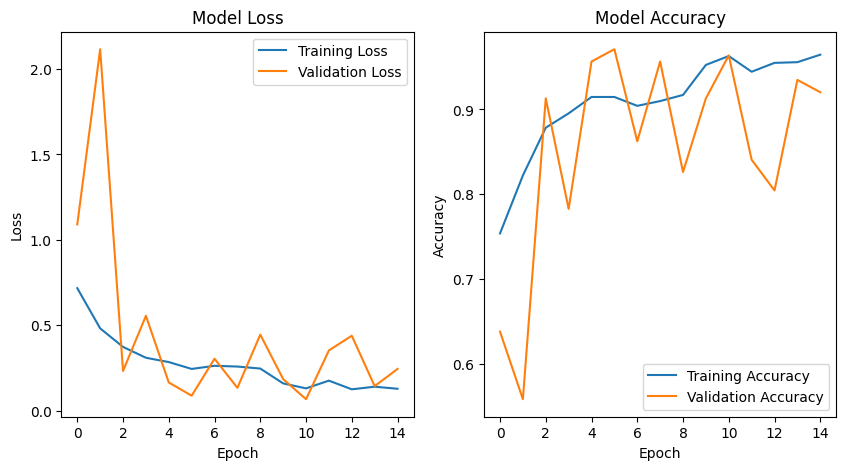

161/161 [==============================] - 12s 68ms/step
precision:  0.8333265013322402
recall:  0.8885641863702974
F1 score:  0.8305301760849164


In [ ]:

pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.SGD(momentum=0.9),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=opt_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Learning Rate

In [ ]:
lr_epoch=15

#lr=0.1

Epoch 1/15
156/156 [==============================] - 46s 234ms/step - loss: 3.9667 - sparse_categorical_accuracy: 0.3519 - val_loss: 8987.6084 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 33s 208ms/step - loss: 1.6886 - sparse_categorical_accuracy: 0.3100 - val_loss: 11.5012 - val_sparse_categorical_accuracy: 0.3841
Epoch 3/15
156/156 [==============================] - 33s 211ms/step - loss: 1.6227 - sparse_categorical_accuracy: 0.3567 - val_loss: 1.9062 - val_sparse_categorical_accuracy: 0.3188
Epoch 4/15
156/156 [==============================] - 33s 210ms/step - loss: 2.2048 - sparse_categorical_accuracy: 0.3390 - val_loss: 194.7512 - val_sparse_categorical_accuracy: 0.3188
Epoch 5/15
156/156 [==============================] - 34s 214ms/step - loss: 2.1957 - sparse_categorical_accuracy: 0.3406 - val_loss: 1.4335 - val_sparse_categorical_accuracy: 0.3696
Epoch 6/15
156/156 [==============================] - 34s 216ms/step - loss: 1.

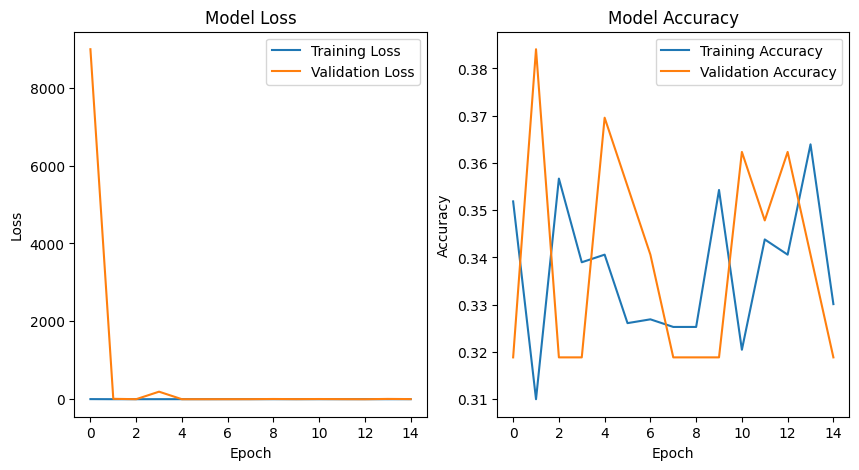

161/161 [==============================] - 12s 67ms/step
precision:  0.08203933747412008
recall:  0.3333333333333333
F1 score:  0.1316718587746625


C:\Users\yashs\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=lr_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

#lr=0.01

Epoch 1/15
156/156 [==============================] - 41s 227ms/step - loss: 5.0435 - sparse_categorical_accuracy: 0.3599 - val_loss: 1861.4163 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
156/156 [==============================] - 34s 218ms/step - loss: 1.8731 - sparse_categorical_accuracy: 0.3366 - val_loss: 1.2241 - val_sparse_categorical_accuracy: 0.3768
Epoch 3/15
156/156 [==============================] - 34s 218ms/step - loss: 1.7742 - sparse_categorical_accuracy: 0.3744 - val_loss: 5.3141 - val_sparse_categorical_accuracy: 0.3768
Epoch 4/15
156/156 [==============================] - 34s 217ms/step - loss: 1.4292 - sparse_categorical_accuracy: 0.3382 - val_loss: 3.2022 - val_sparse_categorical_accuracy: 0.3768
Epoch 5/15
156/156 [==============================] - 34s 216ms/step - loss: 1.4091 - sparse_categorical_accuracy: 0.3341 - val_loss: 1.3200 - val_sparse_categorical_accuracy: 0.3043
Epoch 6/15
156/156 [==============================] - 34s 219ms/step - loss: 1.313

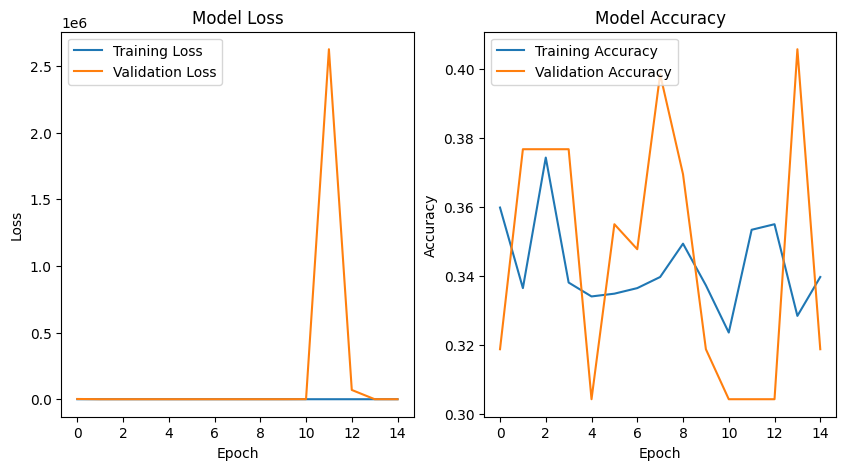

161/161 [==============================] - 12s 67ms/step
precision:  0.17105990783410138
recall:  0.2919166184797357
F1 score:  0.05763391697601011


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=lr_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

#lr=0.001

Epoch 1/15
156/156 [==============================] - 39s 219ms/step - loss: 1.0621 - sparse_categorical_accuracy: 0.6876 - val_loss: 0.7597 - val_sparse_categorical_accuracy: 0.6957
Epoch 2/15
156/156 [==============================] - 34s 217ms/step - loss: 0.6956 - sparse_categorical_accuracy: 0.7432 - val_loss: 5.6292 - val_sparse_categorical_accuracy: 0.4420
Epoch 3/15
156/156 [==============================] - 34s 214ms/step - loss: 0.7445 - sparse_categorical_accuracy: 0.7295 - val_loss: 11.9028 - val_sparse_categorical_accuracy: 0.3696
Epoch 4/15
156/156 [==============================] - 34s 214ms/step - loss: 0.5566 - sparse_categorical_accuracy: 0.8084 - val_loss: 1825.0985 - val_sparse_categorical_accuracy: 0.3188
Epoch 5/15
156/156 [==============================] - 34s 218ms/step - loss: 0.4780 - sparse_categorical_accuracy: 0.8221 - val_loss: 1.1744 - val_sparse_categorical_accuracy: 0.5942
Epoch 6/15
156/156 [==============================] - 34s 216ms/step - loss: 0.46

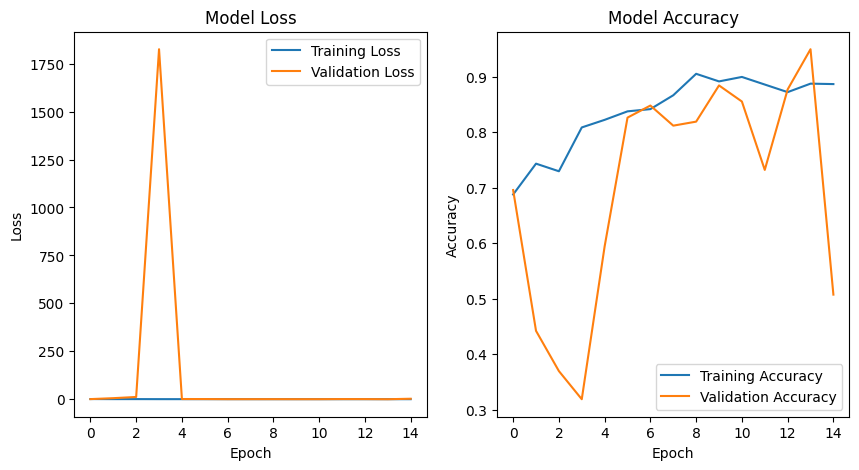

161/161 [==============================] - 12s 68ms/step
precision:  0.3881189554853355
recall:  0.3773977636599082
F1 score:  0.32651877924173084


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=lr_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

lr=0.0001

Epoch 1/15
156/156 [==============================] - 39s 219ms/step - loss: 0.4439 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.2702 - val_sparse_categorical_accuracy: 0.8768
Epoch 2/15
156/156 [==============================] - 34s 216ms/step - loss: 0.2991 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.9749 - val_sparse_categorical_accuracy: 0.7464
Epoch 3/15
156/156 [==============================] - 33s 214ms/step - loss: 0.2560 - sparse_categorical_accuracy: 0.9227 - val_loss: 0.1788 - val_sparse_categorical_accuracy: 0.9348
Epoch 4/15
156/156 [==============================] - 34s 213ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.0573 - val_sparse_categorical_accuracy: 0.9710
Epoch 5/15
156/156 [==============================] - 34s 215ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.2445 - val_sparse_categorical_accuracy: 0.9203
Epoch 6/15
156/156 [==============================] - 33s 211ms/step - loss: 0.1464 -

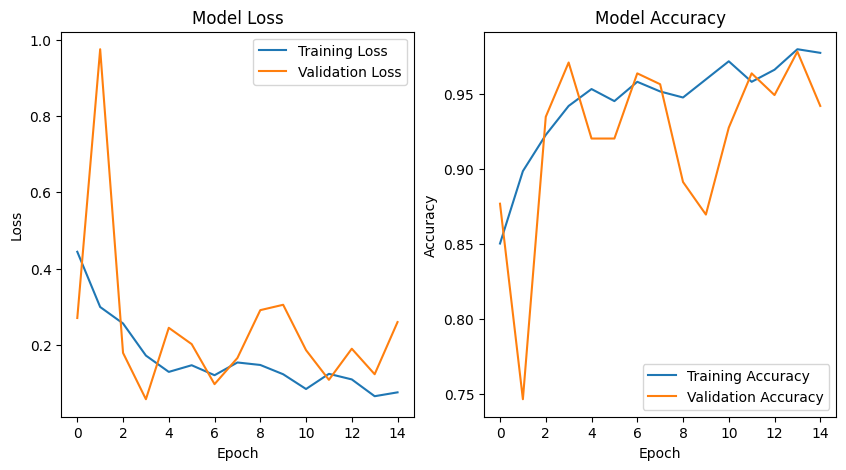

161/161 [==============================] - 11s 65ms/step
precision:  0.9525116462616463
recall:  0.9566679262062476
F1 score:  0.9545752270193651


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)



hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=lr_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

lr=0.00001

Epoch 1/15
156/156 [==============================] - 39s 218ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.3501 - val_sparse_categorical_accuracy: 0.9130
Epoch 2/15
156/156 [==============================] - 33s 213ms/step - loss: 0.3534 - sparse_categorical_accuracy: 0.8696 - val_loss: 0.2486 - val_sparse_categorical_accuracy: 0.8986
Epoch 3/15
156/156 [==============================] - 33s 211ms/step - loss: 0.2816 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9638
Epoch 4/15
156/156 [==============================] - 34s 214ms/step - loss: 0.2241 - sparse_categorical_accuracy: 0.9203 - val_loss: 0.1147 - val_sparse_categorical_accuracy: 0.9783
Epoch 5/15
156/156 [==============================] - 34s 214ms/step - loss: 0.2131 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.0966 - val_sparse_categorical_accuracy: 0.9710
Epoch 6/15
156/156 [==============================] - 33s 212ms/step - loss: 0.1767 -

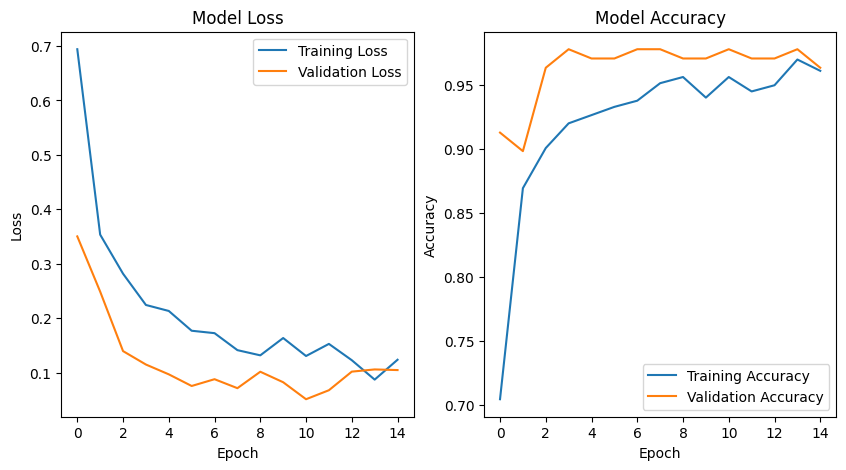

161/161 [==============================] - 12s 69ms/step
precision:  0.8212649572649573
recall:  0.9157630212325719
F1 score:  0.8471773647633091


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(.5)(avg)


hl1 = tf.keras.layers.Dense(1024, activation="elu")(dropout)
hl2 = tf.keras.layers.Dense(1024, activation="elu")(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


base_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=base_model.fit(train_data_generator,epochs=lr_epoch,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

base_model.evaluate(test_data_generator)


y_train_pred = base_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

Best Model - Section 5.2.3

In [ ]:
#Parameters choosen for the Best model are

epoch_val=50                                                          #Implementing all values from hyperparameter tuning
dropout_val=0.5
activation_func="elu"
hidden_layer1 =tf.keras.layers.Dense(1024, activation=activation_func)
hidden_layer2 =tf.keras.layers.Dense(1024, activation=activation_func)
learning_rate_val=0.00001
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_val)


Epoch 1/50
156/156 [==============================] - 46s 235ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.3312 - val_sparse_categorical_accuracy: 0.9130
Epoch 2/50
156/156 [==============================] - 33s 212ms/step - loss: 0.3148 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.2412 - val_sparse_categorical_accuracy: 0.9275
Epoch 3/50
156/156 [==============================] - 32s 206ms/step - loss: 0.2262 - sparse_categorical_accuracy: 0.9243 - val_loss: 0.1793 - val_sparse_categorical_accuracy: 0.9565
Epoch 4/50
156/156 [==============================] - 32s 208ms/step - loss: 0.2134 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.1670 - val_sparse_categorical_accuracy: 0.9348
Epoch 5/50
156/156 [==============================] - 33s 211ms/step - loss: 0.2202 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.1577 - val_sparse_categorical_accuracy: 0.9348
Epoch 6/50
156/156 [==============================] - 34s 215ms/step - loss: 0.1733 -

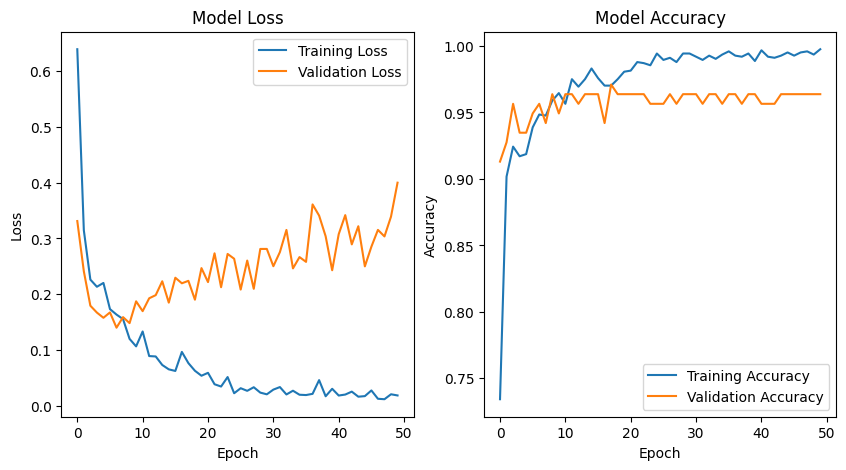

161/161 [==============================] - 12s 66ms/step
precision:  0.87228888362676
recall:  0.9425363267966622
F1 score:  0.8962336128198771


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)

dropout=tf.keras.layers.Dropout(dropout_val)(avg)


hl1 = hidden_layer1(dropout)
hl2 = hidden_layer2(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)


best_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)

best_model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

history=best_model.fit(train_data_generator,epochs=epoch_val,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

best_model.evaluate(test_data_generator)


y_train_pred = best_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

The Model here demonstrates clear signs of Overfitting for the following reasons
 1) Validation loss is increasing as the Training Loss is decreasing after epoch number 8.
 2) Validation Accurary came out to be much higher than the Testing Accuracy.
 3) The training is going on for too long.

We can hence conclude we have engineered overfitting in this case.

To deal with Overfitting we will include the following
 1) Regularization - l1/l2 regularization for the model
 2) EarlyStopping - Early Stopping for val_loss if there is no change in the loss
 3) Dropout - Increasing the dropout from 0.5 to 0.8, which was the 2nd best droput result we had from hyperparameter tuning
 4) k-fold Validation - We will Validate our model in 10 folds and see if the model we got is a good model and retrain it using the whole dataset

Initialsing K fold - Section 5.2.4

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=True)     # spliting the dataset into 5 folds

In [ ]:
train_image_list= np.array(train_data["images"])  #Passing the Images name from Training Dataset as a list for k-fold valdation

Found 1104 validated image filenames belonging to 3 classes.
Found 276 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
138/138 [==============================] - 46s 262ms/step - loss: 24.7813 - sparse_categorical_accuracy: 0.5199 - val_loss: 24.2501 - val_sparse_categorical_accuracy: 0.7935
Epoch 2/20
138/138 [==============================] - 33s 237ms/step - loss: 24.1467 - sparse_categorical_accuracy: 0.7536 - val_loss: 23.6881 - val_sparse_categorical_accuracy: 0.9239
Epoch 3/20
138/138 [==============================] - 33s 236ms/step - loss: 23.6422 - sparse_categorical_accuracy: 0.8460 - val_loss: 23.2636 - val_sparse_categorical_accuracy: 0.9384
Epoch 4/20
138/138 [==============================] - 33s 235ms/step - loss: 23.2490 - sparse_categorical_accuracy: 0.8714 - val_loss: 22.9204 - val_sparse_categorical_accuracy: 0.9529
Epoch 5/20
138/138 [======================

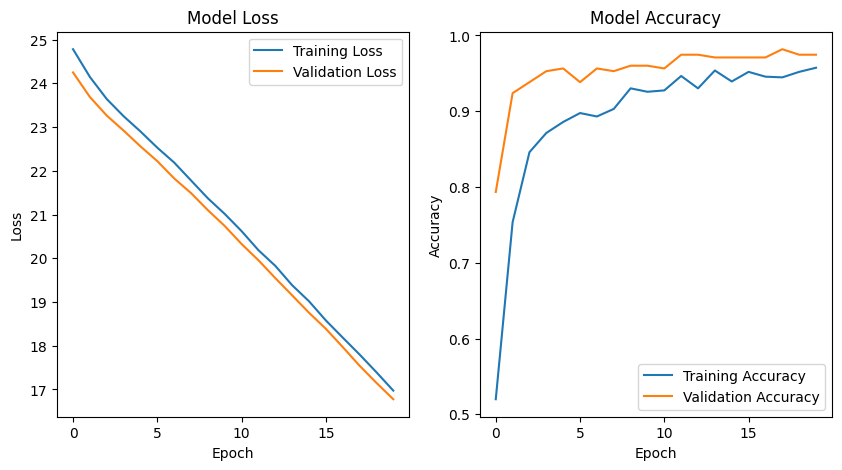

Score for fold 1: loss of 16.7501277923584; sparse_categorical_accuracy of 96.7391312122345%
Found 1104 validated image filenames belonging to 3 classes.
Found 276 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/20
138/138 [==============================] - 39s 248ms/step - loss: 24.7121 - sparse_categorical_accuracy: 0.5480 - val_loss: 24.2203 - val_sparse_categorical_accuracy: 0.7138
Epoch 2/20
138/138 [==============================] - 33s 241ms/step - loss: 24.0393 - sparse_categorical_accuracy: 0.7763 - val_loss: 23.6985 - val_sparse_categorical_accuracy: 0.8732
Epoch 3/20
138/138 [==============================] - 34s 244ms/step - loss: 23.5830 - sparse_categorical_accuracy: 0.8487 - val_loss: 23.2287 - val_sparse_categorical_accuracy: 0.9384
Epoch 4/20
138/138 [==============================] - 33s 241ms/step - loss: 23.2086 - sparse_categorical_accuracy: 0.8714 - val_loss:

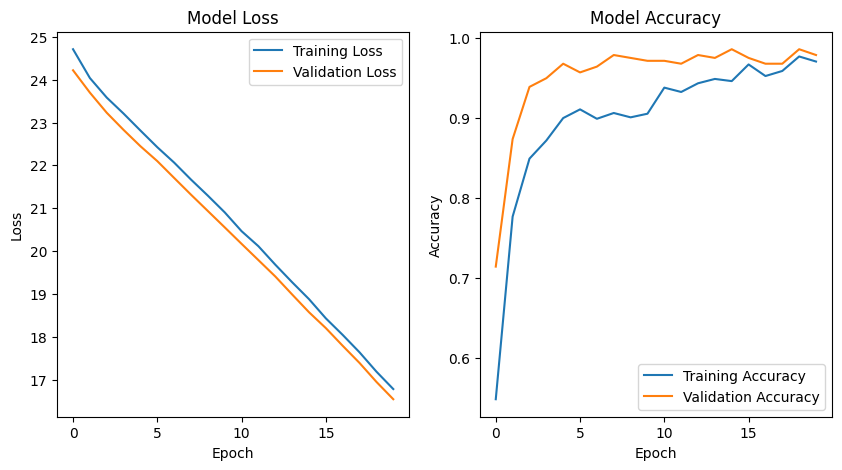

Score for fold 2: loss of 16.520389556884766; sparse_categorical_accuracy of 97.46376872062683%
Found 1104 validated image filenames belonging to 3 classes.
Found 276 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/20
138/138 [==============================] - 39s 250ms/step - loss: 24.6751 - sparse_categorical_accuracy: 0.5616 - val_loss: 24.1500 - val_sparse_categorical_accuracy: 0.8551
Epoch 2/20
138/138 [==============================] - 34s 248ms/step - loss: 24.0126 - sparse_categorical_accuracy: 0.7935 - val_loss: 23.6579 - val_sparse_categorical_accuracy: 0.9275
Epoch 3/20
138/138 [==============================] - 34s 247ms/step - loss: 23.5562 - sparse_categorical_accuracy: 0.8587 - val_loss: 23.3011 - val_sparse_categorical_accuracy: 0.9130
Epoch 4/20
138/138 [==============================] - 34s 247ms/step - loss: 23.1601 - sparse_categorical_accuracy: 0.8913 - val_lo

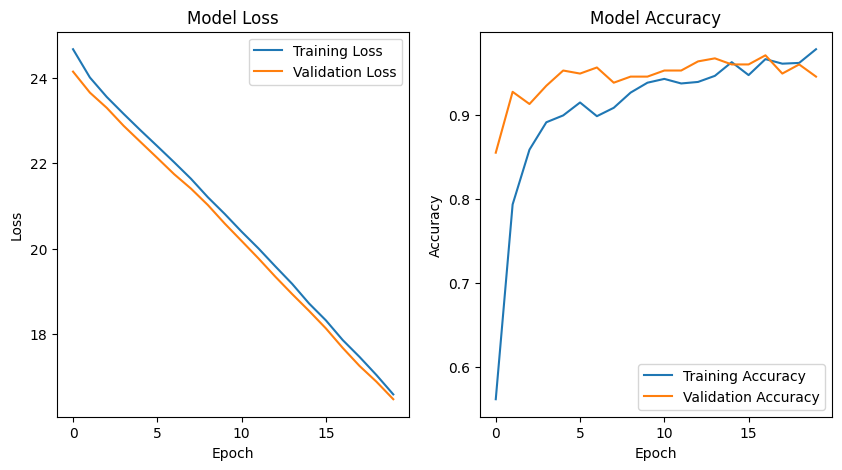

Score for fold 3: loss of 16.442028045654297; sparse_categorical_accuracy of 97.10144996643066%
Found 1104 validated image filenames belonging to 3 classes.
Found 276 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
138/138 [==============================] - 39s 248ms/step - loss: 24.7443 - sparse_categorical_accuracy: 0.5163 - val_loss: 24.1880 - val_sparse_categorical_accuracy: 0.8623
Epoch 2/20
138/138 [==============================] - 33s 241ms/step - loss: 24.0850 - sparse_categorical_accuracy: 0.7482 - val_loss: 23.6666 - val_sparse_categorical_accuracy: 0.9058
Epoch 3/20
138/138 [==============================] - 34s 247ms/step - loss: 23.5518 - sparse_categorical_accuracy: 0.8668 - val_loss: 23.2908 - val_sparse_categorical_accuracy: 0.9203
Epoch 4/20
138/138 [==============================] - 34s 243ms/step - loss: 23.2089 - sparse_categorical_accuracy: 0.8569 - val_lo

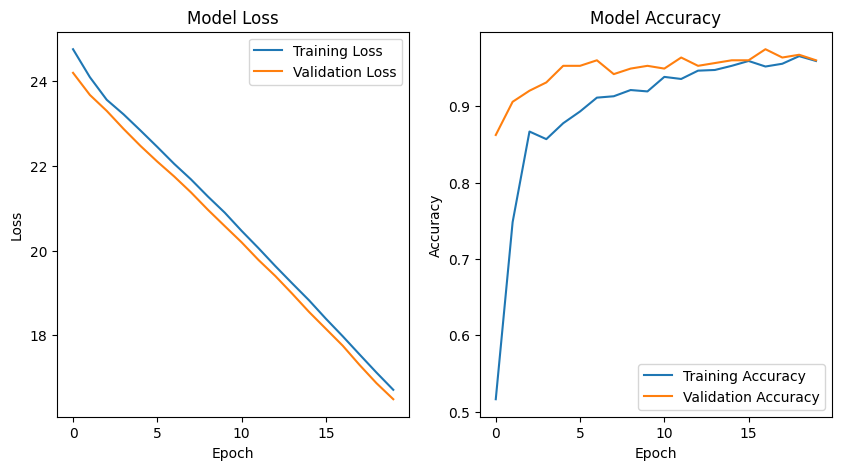

Score for fold 4: loss of 16.525991439819336; sparse_categorical_accuracy of 95.28985619544983%
Found 1104 validated image filenames belonging to 3 classes.
Found 276 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
138/138 [==============================] - 39s 249ms/step - loss: 24.7653 - sparse_categorical_accuracy: 0.5254 - val_loss: 24.2978 - val_sparse_categorical_accuracy: 0.7319
Epoch 2/20
138/138 [==============================] - 33s 239ms/step - loss: 24.0935 - sparse_categorical_accuracy: 0.7699 - val_loss: 23.7757 - val_sparse_categorical_accuracy: 0.8551
Epoch 3/20
138/138 [==============================] - 33s 239ms/step - loss: 23.6138 - sparse_categorical_accuracy: 0.8415 - val_loss: 23.3865 - val_sparse_categorical_accuracy: 0.8949
Epoch 4/20
138/138 [==============================] - 34s 243ms/step - loss: 23.2835 - sparse_categorical_accuracy: 0.8514 - val_lo

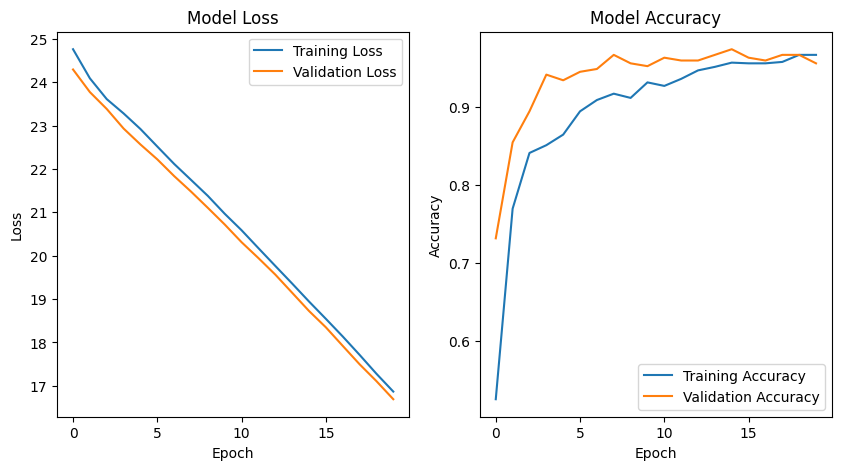

Score for fold 5: loss of 16.676132202148438; sparse_categorical_accuracy of 96.37681245803833%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 16.7501277923584 - Accuracy: 96.7391312122345%
------------------------------------------------------------------------
> Fold 2 - Loss: 16.520389556884766 - Accuracy: 97.46376872062683%
------------------------------------------------------------------------
> Fold 3 - Loss: 16.442028045654297 - Accuracy: 97.10144996643066%
------------------------------------------------------------------------
> Fold 4 - Loss: 16.525991439819336 - Accuracy: 95.28985619544983%
------------------------------------------------------------------------
> Fold 5 - Loss: 16.676132202148438 - Accuracy: 96.37681245803833%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 96.5

In [ ]:

#Parameters choosen for the Best model are
patience_val=5
batch_size=8
epoch_val=20
dropout_val=0.8
activation_func="elu"
hidden_layer1 =tf.keras.layers.Dense(1024, activation=activation_func,kernel_regularizer=tf.keras.regularizers.l2(0.01))
hidden_layer2 =tf.keras.layers.Dense(1024, activation=activation_func,kernel_regularizer=tf.keras.regularizers.l2(0.01))
learning_rate_val=0.00001
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_val)


acc_per_fold = []
loss_per_fold = []
model_list=[]
fold_no = 1
epoch_num=30
batch_size=8
kfold = KFold(n_splits=num_folds, shuffle=True)
for train_index, val_index in kfold.split(train_image_list):      #iterating through each fold for invidual modile compilation and fitting
    trainData = train_image_list[train_index]
    valData = train_image_list[val_index]
    train_df = train_data.loc[train_data["images"].isin(list(trainData))]
    valid_df = train_data.loc[train_data["images"].isin(list(valData))]

    k_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.10,
                                  height_shift_range = 0.10,
                                  horizontal_flip = True
                                  )

    k_train_data_generator = k_datagen.flow_from_dataframe(            #making new datagenerators on the data obtained for that fold
    train_df,
    x_col = 'images',
    y_col = 'target',
    classes=['NORMAL', 'COVID19', 'PNEUMONIA'],
    target_size=(299, 299),
    batch_size = batch_size,
    shuffle = True,
    seed = 42,
    class_mode = 'sparse',
    validate_filenames = True,
    )

    k_val_data_generator = k_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'images',
    y_col = 'target',
    classes=['NORMAL', 'COVID19', 'PNEUMONIA'],
    target_size=(299, 299),
    batch_size = batch_size,
    shuffle = True,
    seed = 42,
    class_mode = 'sparse',
    validate_filenames = True,
    )



    pretrained_model = tf.keras.applications.InceptionV3(
                                               weights = 'imagenet',
                                               include_top = False)

    avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model.output)
    dropout=tf.keras.layers.Dropout(dropout_val)(avg)  # increasing the value of dropout
    hl1 = tf.keras.layers.Dense(1024, activation="elu",kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout) #added l2 regularisation
    hl2 = tf.keras.layers.Dense(1024, activation="elu",kernel_regularizer=tf.keras.regularizers.l2(0.01))(hl1)
    output = tf.keras.layers.Dense(3, activation="softmax")(hl2)
    inceptionnet_model = tf.keras.models.Model(inputs=pretrained_model.input, outputs=output)
    inceptionnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
                 loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_val) #inclduing a call back for early stopping
    history=inceptionnet_model.fit(k_train_data_generator,epochs=epoch_val, validation_data=k_val_data_generator,
                                   verbose=1,callbacks=[callback])  #calling the call back of early stopping

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].set_title('Model Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].set_title('Model Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Show the plot
    plt.show()

    # Generate generalization metrics
    scores = inceptionnet_model.evaluate(k_val_data_generator, verbose=0)
    print(f'Score for fold {fold_no}: {inceptionnet_model.metrics_names[0]} of {scores[0]}; {inceptionnet_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

    tf.keras.backend.clear_session()                   #clearning up space from backend to decrease memory usage
    gc.collect()



# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Optimum model  - Section 5.2.5

In [ ]:
#Parameters choosen for the Optimum model are

epoch_val=100
dropout_val=0.8
patience_val=5
activation_func="elu"
hidden_layer1 =tf.keras.layers.Dense(1024,
                                     activation=activation_func,kernel_regularizer=tf.keras.regularizers.l2(0.01)) #added l2
hidden_layer2 =tf.keras.layers.Dense(1024,
                                     activation=activation_func,kernel_regularizer=tf.keras.regularizers.l2(0.01)) #added l2
learning_rate_val=0.00001
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_val)


Epoch 1/100
156/156 [==============================] - 48s 243ms/step - loss: 24.6503 - sparse_categorical_accuracy: 0.5588 - val_loss: 24.0855 - val_sparse_categorical_accuracy: 0.7971
Epoch 2/100
156/156 [==============================] - 33s 208ms/step - loss: 23.9453 - sparse_categorical_accuracy: 0.8068 - val_loss: 23.6501 - val_sparse_categorical_accuracy: 0.8043
Epoch 3/100
156/156 [==============================] - 33s 213ms/step - loss: 23.4412 - sparse_categorical_accuracy: 0.8567 - val_loss: 23.1363 - val_sparse_categorical_accuracy: 0.9203
Epoch 4/100
156/156 [==============================] - 34s 216ms/step - loss: 23.0101 - sparse_categorical_accuracy: 0.8776 - val_loss: 22.6180 - val_sparse_categorical_accuracy: 0.9710
Epoch 5/100
156/156 [==============================] - 36s 227ms/step - loss: 22.6086 - sparse_categorical_accuracy: 0.8913 - val_loss: 22.2600 - val_sparse_categorical_accuracy: 0.9493
Epoch 6/100
156/156 [==============================] - 34s 218ms/step 

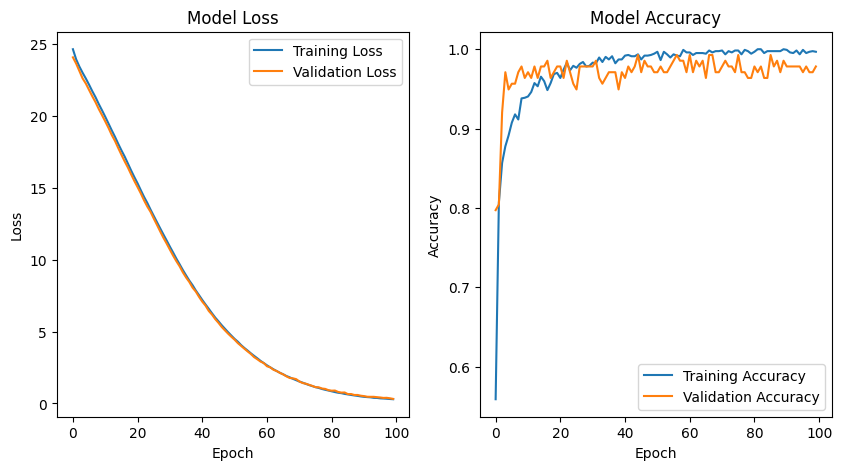

161/161 [==============================] - 13s 73ms/step
precision:  0.9190533979580633
recall:  0.9591467276673985
F1 score:  0.9336837061646461


In [ ]:
pretrained_inception_cnn = tf.keras.applications.InceptionV3(                          #calling the CNN model from keras
                                               weights = 'imagenet',
                                               include_top = False)

avg = tf.keras.layers.GlobalAveragePooling2D()(pretrained_inception_cnn.output)          #average pooling the output of CNN

dropout=tf.keras.layers.Dropout(dropout_val)(avg)                                        #adding dropout to the model


hl1 = hidden_layer1(dropout)                                                              #implmenting a two layer model with 1024 nodes
hl2 = hidden_layer2(hl1)

output = tf.keras.layers.Dense(3, activation="softmax")(hl2)                              #adding an output layer with 3 nueron each for one class


optimum_model = tf.keras.models.Model(inputs=pretrained_inception_cnn.input, outputs=output)  #calling the model object with input and output layer in a serialized format

optimum_model.compile(optimizer = optimizer,                                                 #compiling the model
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_val)   #added earlystopping
history=optimum_model.fit(train_data_generator,epochs=epoch_val,validation_data=val_data_generator,verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))                                            #plotting for validation loss and accuracy

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

optimum_model.evaluate(test_data_generator)                                #evaluating on the test dataset from test data genrator object


y_train_pred = optimum_model.predict(test_data_generator)
y_train_pred = np.argmax(y_train_pred,axis=1)

confusion_matrix(test_data_generator.classes, y_train_pred)

p = precision_score(test_data_generator.classes, y_train_pred, average = 'macro')
r = recall_score(test_data_generator.classes, y_train_pred, average = 'macro')
f = f1_score(test_data_generator.classes, y_train_pred, average = 'macro')

print('precision: ', p)
print('recall: ', r)
print('F1 score: ', f)

In [ ]:
optimum_model.summary()                                               # using keras function to call for summary of model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

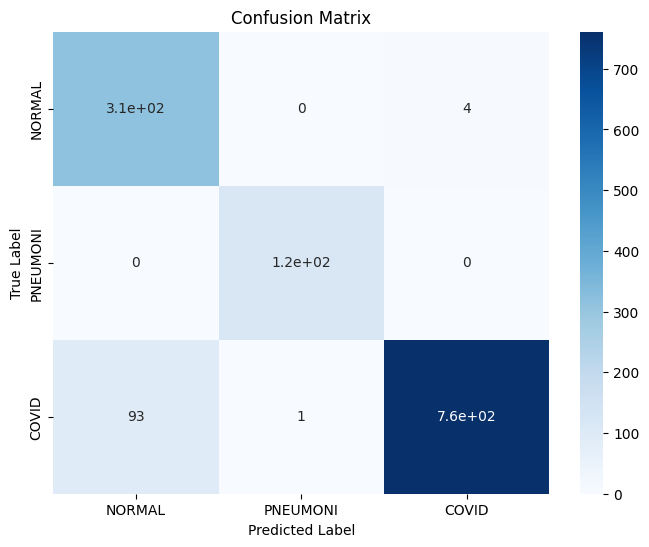

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(test_data_generator.classes, y_train_pred)           #using inbuilt function for plotitng confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['NORMAL','PNEUMONI','COVID'], yticklabels=['NORMAL','PNEUMONI','COVID'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()